# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
import warnings
warnings.filterwarnings('ignore')

sciper = {'student_1': 281779,
          'student_2': 237289}
seed = sciper['student_1'] + sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

Using TensorFlow backend.


In [2]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    
    plt.ylim([-0.5,len(activeidxes)-0.5])
    # J'ai rajouté ..
    #if(all(i < len(dictionaries['P']) for i in activeidxes)):
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    # J'ai rajouté ..
    #if(all(i < len(dictionaries['T']) for i in activeidxes)):
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    try:
        log = History.history
    except:
        pass
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
    
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

In [3]:
"""
Helper functions to save and load objects in pickle files.
"""

import pickle

def save_obj(obj, name):
    """
    Saves an object in a pickle file.
    """
    with open('data2/pickle/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    """
    Loads an object from a pickle file.
    """
    with open('data2/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [4]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0]
    tick = 0
    print(midi_file)
    print('length of event: ', len(events))
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

chorpus/sessiontune0.mid
length of event:  273
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################



In [5]:
datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T": [], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

4623/45854 melodies retained


### Solution

**1.** Downloaded the MIDI files.

**2.** The random subset of melodies is generated by the code above. Only 10% of them are retained.

**3.** We parse here the data set with the helper function `parseMIDI`.

In [6]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick = 0
    start_tick = dict()
    for event in events:
        tick += event.tick
        if event.name == 'Note On':
            note = event.data[0]
            start_tick[note] = tick
        elif event.name == 'Note Off':
            note = event.data[0]
            P.append(note)
            T.append(tick - start_tick[note] + 1)
    return P, T

**4.** Assign the pitches and the durations of all the melodies retained in the `dataset` dictionary.

In [7]:
for label in dataset.keys():
    Pseq, Tseq = parseMIDI(datapath + label + ".mid")
    dataset[label]['T'] = Tseq
    dataset[label]['P'] = Pseq

**5.** We select randomly two melodies (labels) and display them.

In [8]:
random_melodies = np.random.choice(list(dataset.keys()), 2)

print('We are going to display the melodies {0} and {1}.'.format(random_melodies[0], random_melodies[1]))

We are going to display the melodies sessiontune18306 and sessiontune21871.


In [9]:
for label in random_melodies:
    print(label)
    print("MIDI events")
    display(datapath + label + ".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')

sessiontune18306
MIDI events
chorpus/sessiontune18306.mid
length of event:  483
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 62 	 Note On 	 105
240 	 62 	 Note Off 	 0
241 	 67 	 Note On 	 80
480 	 67 	 Note Off 	 0
481 	 67 	 Note On 	 80
720 	 67 	 Note Off 	 0
721 	 62 	 Note On 	 80
960 	 62 	 Note Off 	 0
961 	 67 	 Note On 	 95
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60161 	 67 	 Note On 	 80
60320 	 67 	 Note Off 	 0
60321 	 65 	 Note On 	 80
60480 	 65 	 Note Off 	 0
60481 	 67 	 Note On 	 95
60960 	 67 	 Note Off 	 0
60961 	 67 	 Note On 	 80
61440 	 67 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 160, 160, 160, 240, 240, 480, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240

The representation seems to be correct.

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

**1.** In order to gather a list of all possible pitches and durations, we use the `set` data structure to get rid of duplicates. We make here a function `tokenize` which takes the dataset and returns the tokenized data set as well as the dictionaries.

In [10]:
def tokenize(dataset):
    # Collecting the lists of all pitches and durations (without repetition)
    possible_pitches = set()
    possible_durations = set()

    for label in dataset.keys():
        possible_pitches |= set(dataset[label]['P'])
        possible_durations |= set(dataset[label]['T'])

    possible_pitches = list(possible_pitches)
    possible_durations = list(possible_durations)
    
    dictionaries = dict()
    dictionaries['P'] = dict((number, pitch) for number, pitch in enumerate(possible_pitches))
    dictionaries['T'] = dict((number, duration) for number, duration in enumerate(possible_durations))
    
    tokenized_dataset = dict()
    
    for label in dataset.keys():
        tokenized_dataset[label] = dict()
        
        pitches_indexes = []
        for pitch in dataset[label]['P']:
            pitches_indexes.append(possible_pitches.index(pitch))
        tokenized_dataset[label]['P'] = pitches_indexes
        
        durations_indexes = []
        for duration in dataset[label]['T']:
            durations_indexes.append(possible_durations.index(duration))
        tokenized_dataset[label]['T'] = durations_indexes
        
    return tokenized_dataset, dictionaries

**2.** We can translate the pitch/duration sequence of each melody to the integer representation using the above `tokenize` function.

In [11]:
tokenized_dataset, dictionaries = tokenize(dataset)

**3.** We select randomly two melodies (labels) and display them.

In [12]:
random_melodies = np.random.choice(list(dataset.keys()), 2)

print('We are going to display the melodies {0} and {1}.'.format(random_melodies[0], random_melodies[1]))

We are going to display the melodies sessiontune4372 and sessiontune21585.


In [13]:
for label in random_melodies:
    print('Label name :', label)
    print('\n')
    print('Note representation')
    print(dataset[label])
    print('\n')
    print('Translated representation')
    print(tokenized_dataset[label])
    print('\n')
    
    # Check if the translation is correct
    decrypted_T = [dictionaries['T'][x] for x in tokenized_dataset[label]['T']]
    decrypted_P = [dictionaries['P'][x] for x in tokenized_dataset[label]['P']]
    if decrypted_T == dataset[label]['T'] and decrypted_P == dataset[label]['P']:
        print('The translation is correct')
    else:
        print('The translation is NOT correct')
    print('\n\n')

Label name : sessiontune4372


Note representation
{'T': [240, 320, 160, 240, 320, 160, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 720, 320, 160, 240, 320, 160, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 480, 240, 320, 160, 240, 320, 160, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 720, 320, 160, 240, 320, 160, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 320, 160, 240, 320, 160, 240, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 480, 240, 320, 160, 240, 320, 160, 240, 320, 160, 240, 240, 480, 240, 480, 240, 320, 160, 240, 480, 240, 480, 240, 480], 'P': [67, 60, 62, 60, 64, 62, 60, 64, 67, 72, 67, 69, 71, 72, 67, 64, 62, 60, 69, 60, 62, 60, 64, 62, 60, 64, 67, 72, 67, 69, 71, 72, 67, 64, 62, 60, 60, 67, 60, 62, 60, 6

The translation into integer seem to be correct.

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

#### Rare event suppression

**1.** We collect here all the pitches and all the durations of the original data set and plot their distribution.

In [14]:
all_pitches = []
all_durations = []

for label in dataset.keys():
    all_pitches.extend(dataset[label]['P'])
    all_durations.extend(dataset[label]['T'])

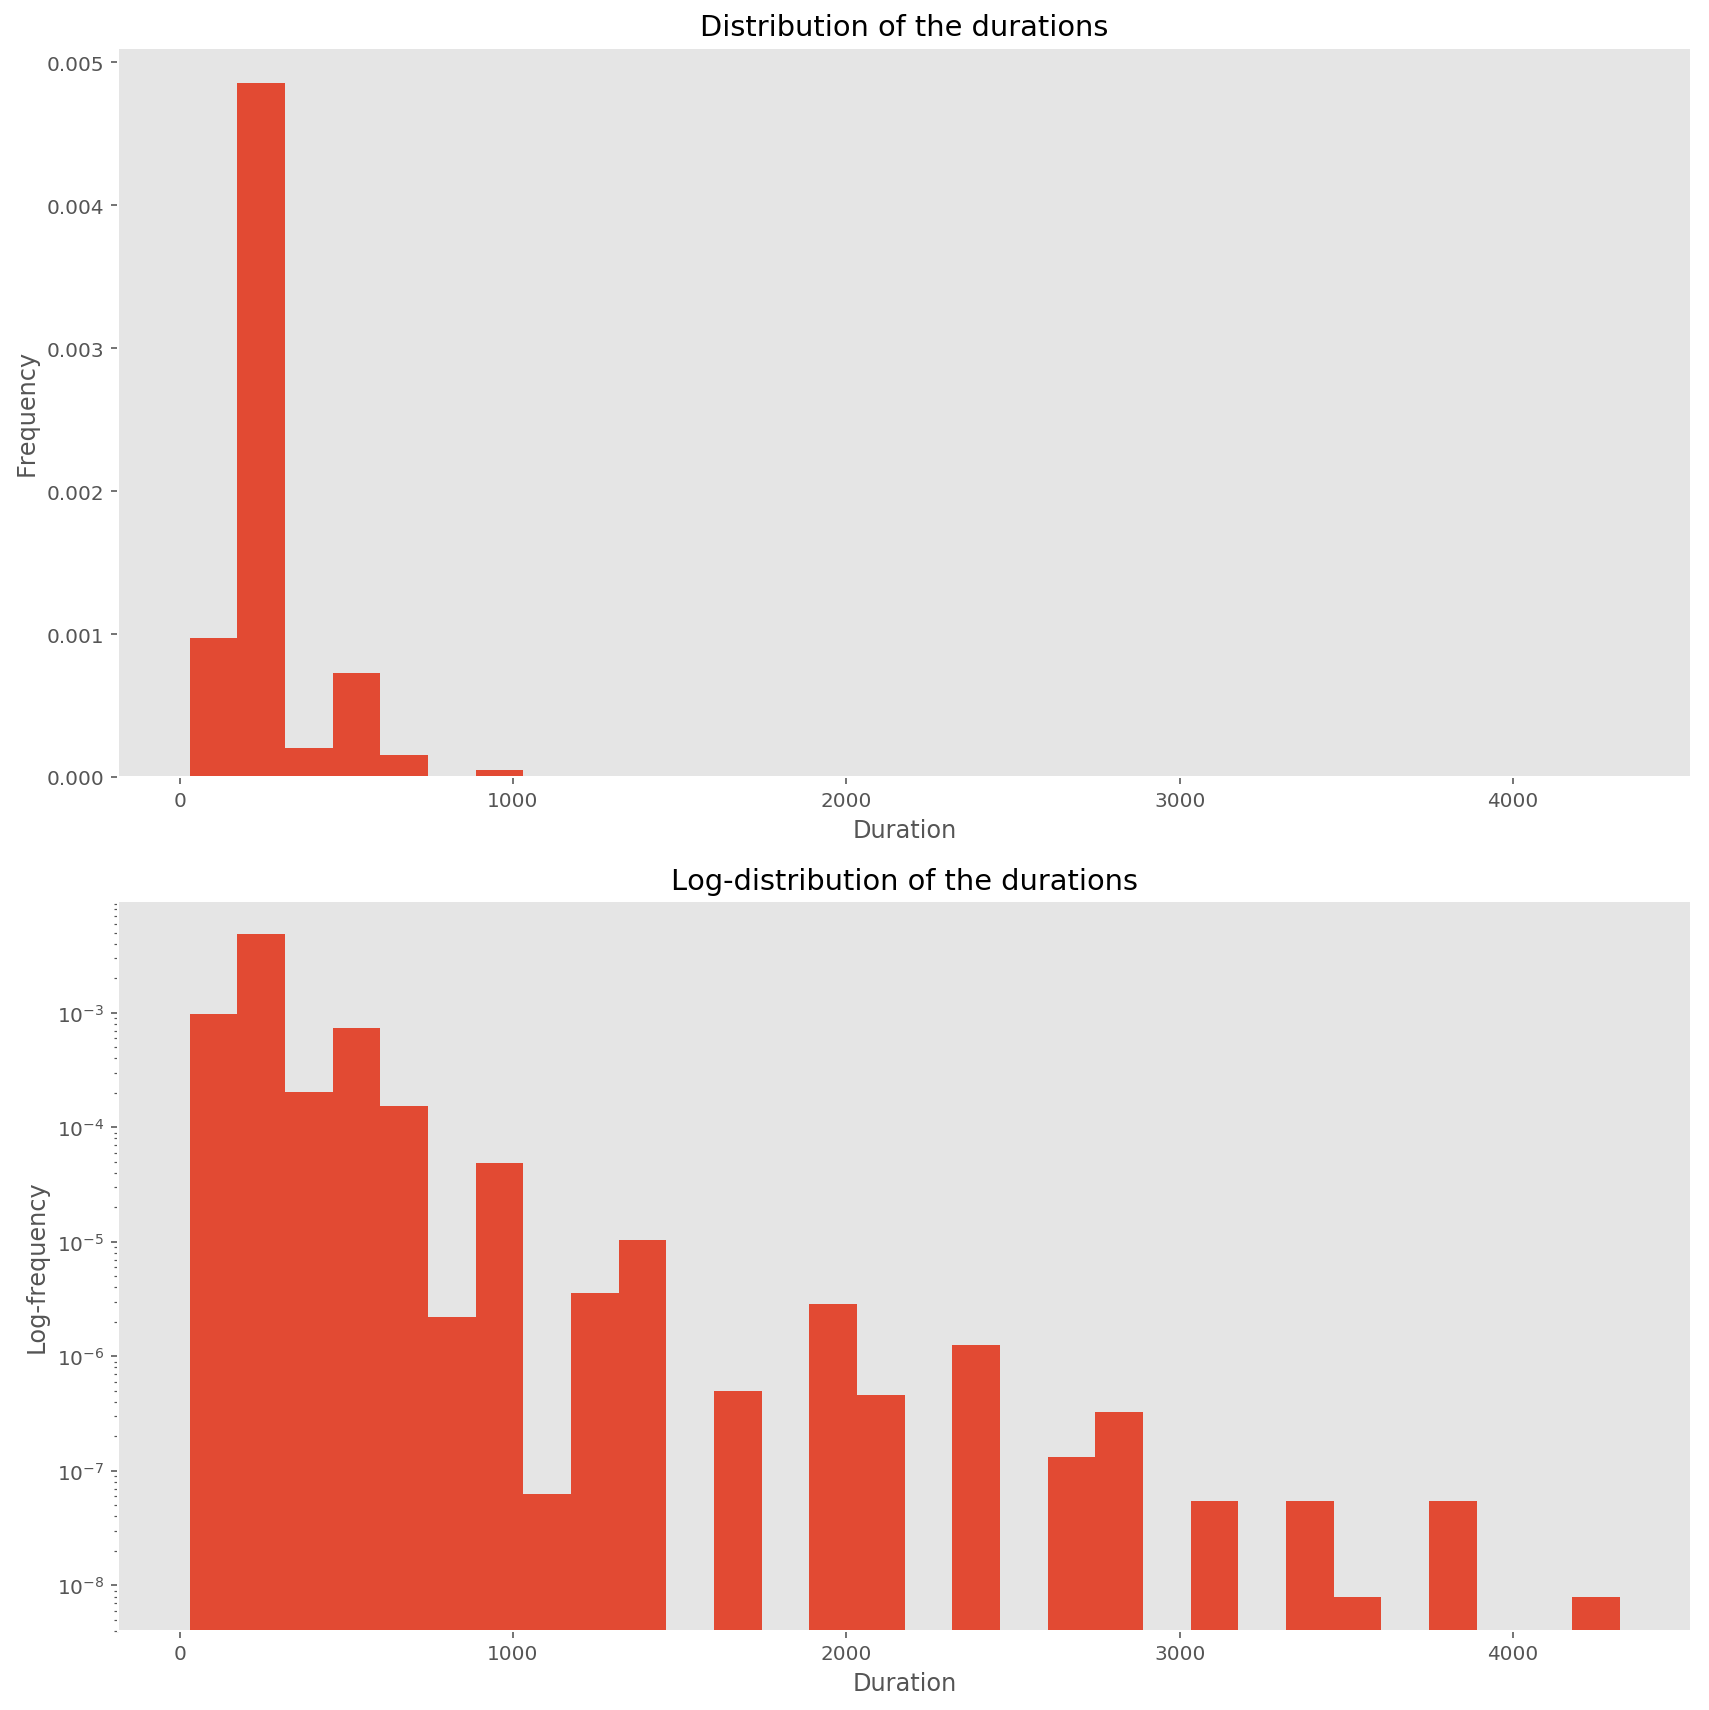

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].hist(all_durations, bins=30, density=True)
ax[0].set_title('Distribution of the durations')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Duration')

ax[1].hist(all_durations, bins=30, density=True)
ax[1].set_title('Log-distribution of the durations')
ax[1].set_ylabel('Log-frequency')
ax[1].set_xlabel('Duration')
ax[1].set_yscale('log', nonposy='clip')

plt.tight_layout()

plt.show()

In [16]:
print('There are {0} different durations and '
      '{1} different pitches in the data set'.format(len(set(all_durations)), len(set(all_pitches))))

There are 65 different durations and 48 different pitches in the data set


**2.** We remove melodies containing very rare durations (such as almost 5% of the melodies are removed).

In [17]:
from collections import Counter

durations_counter = Counter(all_durations)

durations, durations_count = zip(*durations_counter.items())
durations = np.array(durations)
durations_count = np.array(durations_count)
durations_frequencies = durations_count/np.sum(durations_count)

arg = np.argsort(durations_frequencies)
sorted_durations = durations[arg]
sorted_frequencies = durations_frequencies[arg]

In [18]:
def are_durations_in_melody(melody, durations):
    c = set(durations).intersection(set(dataset[melody]['T']))
    return len(c) > 0

In [19]:
filtered_dataset = dataset.copy()

for threshold in range(len(sorted_durations)):
    num_removed = 0
    to_be_removed = sorted_durations[:threshold]
    
    for label in dataset.keys():
        if are_durations_in_melody(label, to_be_removed):
            num_removed = num_removed + 1
    
    removed_percentage = num_removed/len(filtered_dataset)
    
    if removed_percentage >= 0.05:
        threshold = threshold - 1
        num_removed = 0
        to_be_removed = sorted_durations[:threshold]
        for label in dataset.keys():
            if are_durations_in_melody(label, to_be_removed):
                num_removed = num_removed + 1
                
                # Remove the melody from the filtered data set
                del filtered_dataset[label]
        break


to_be_removed_string = ' '.join([str(x) for x in to_be_removed])        
print('By using the frequency threshold of',
      round(sorted_frequencies[threshold - 1], 7),
      'the melodies containing the following durations should be deleted :',
      to_be_removed_string, '.\n')
print('In total,', len(to_be_removed),
      'durations are concerned and',
      round(num_removed/len(dataset)*100, 2),
      '% of the melodies of the dataset.')
print('There are finally only {} durations remaining.'.format(len(set(all_durations)) - len(to_be_removed)))

By using the frequency threshold of 0.0002549 the melodies containing the following durations should be deleted : 2150 780 3600 1420 1320 4320 940 790 280 213 420 106 700 1080 460 200 45 1120 220 400 3360 3120 3840 560 1430 2040 600 300 144 50 2640 100 1280 90 2880 310 2160 840 1680 950 710 640 150 30 350 2400 110 800 .

In total, 48 durations are concerned and 4.8 % of the melodies of the dataset.
There are finally only 17 durations remaining.


**3.** We recompute here the duration dictionary using the filtered data set.

In [20]:
tokenized_filtered_dataset, filtered_dictionaries = tokenize(filtered_dataset)

duration_dictionary = filtered_dictionaries['T']

We gather here all the durations of the filtered data set and plot the new distribution.

In [21]:
all_filtered_durations = []

for label in filtered_dataset.keys():
    all_filtered_durations.extend(filtered_dataset[label]['T'])

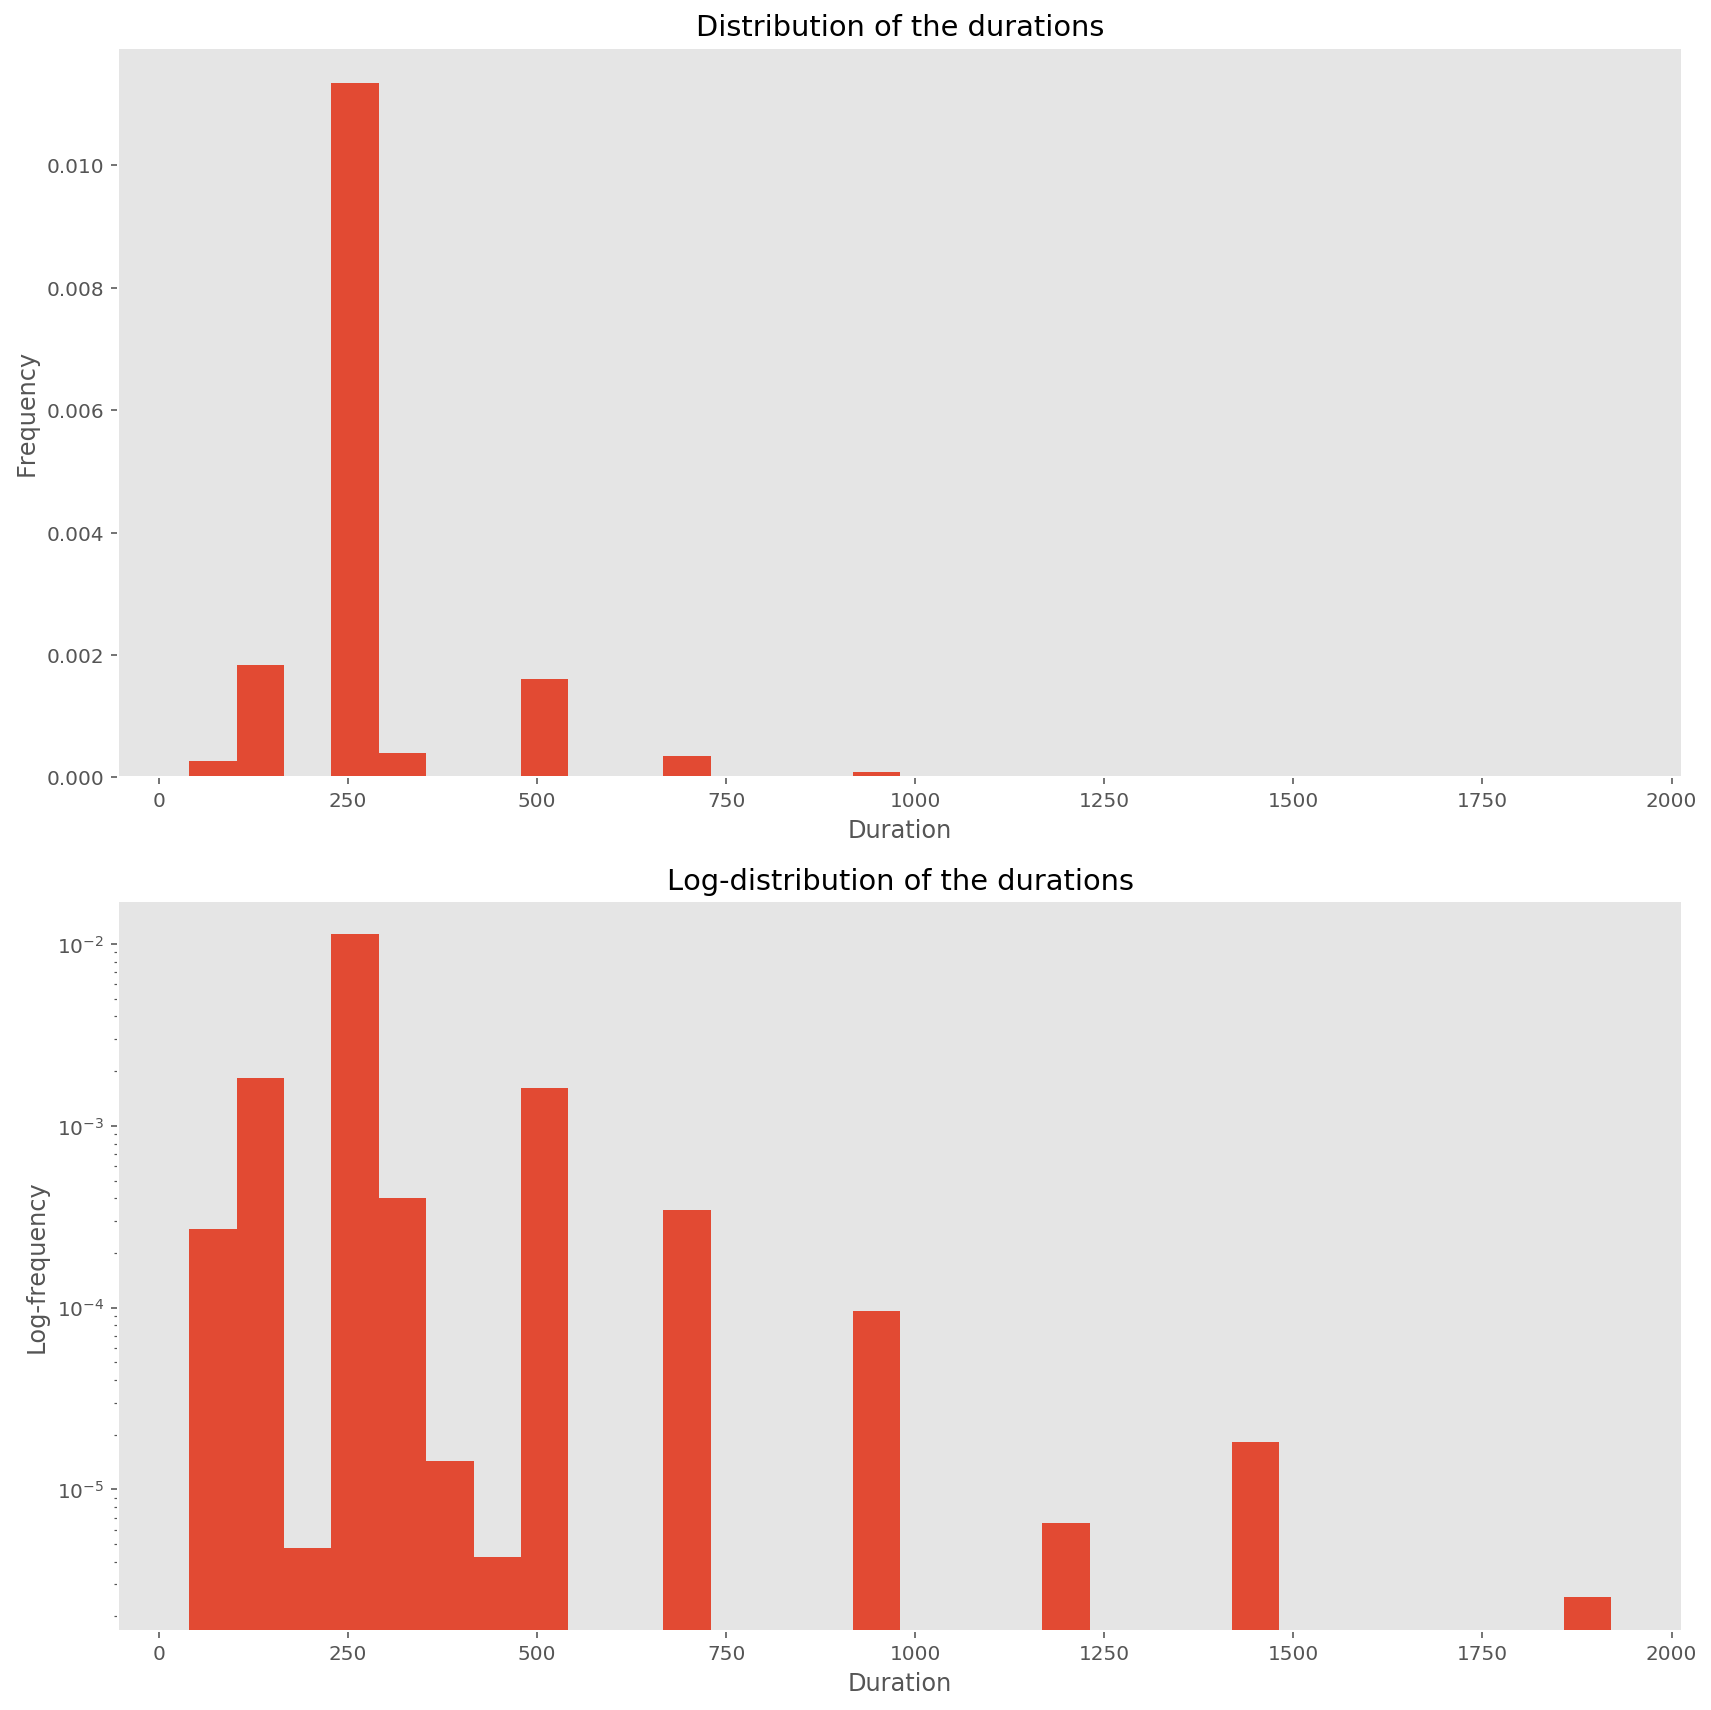

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].hist(all_filtered_durations, bins=30, density=True)
ax[0].set_title('Distribution of the durations')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Duration')

ax[1].hist(all_filtered_durations, bins=30, density=True)
ax[1].set_title('Log-distribution of the durations')
ax[1].set_ylabel('Log-frequency')
ax[1].set_xlabel('Duration')
ax[1].set_yscale('log', nonposy='clip')

plt.tight_layout()

plt.show()

#### Transposition invariance

In [14]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

**1.** We noticed that a few melody contain 0 pitches and durations which makes the function `transposeDataset` throw an error. Thus, we first delete them here.

In [23]:
for label in list(filtered_dataset.keys()):
    if len(filtered_dataset[label]['T']) == 0 or len(filtered_dataset[label]['P']) == 0:
        del filtered_dataset[label]

We can now transpose the filtered data set with the given helper function `transposeDataset`.

In [24]:
transposed_dataset = transposeDataset(filtered_dataset)

**2.** Finally, we gather here the pitches before and after the transposition and plot them.

In [25]:
pitches_before = []
pitches_after = []

for label in filtered_dataset.keys():
    pitches_before.extend(filtered_dataset[label]['P'])
    pitches_after.extend(transposed_dataset[label]['P'])

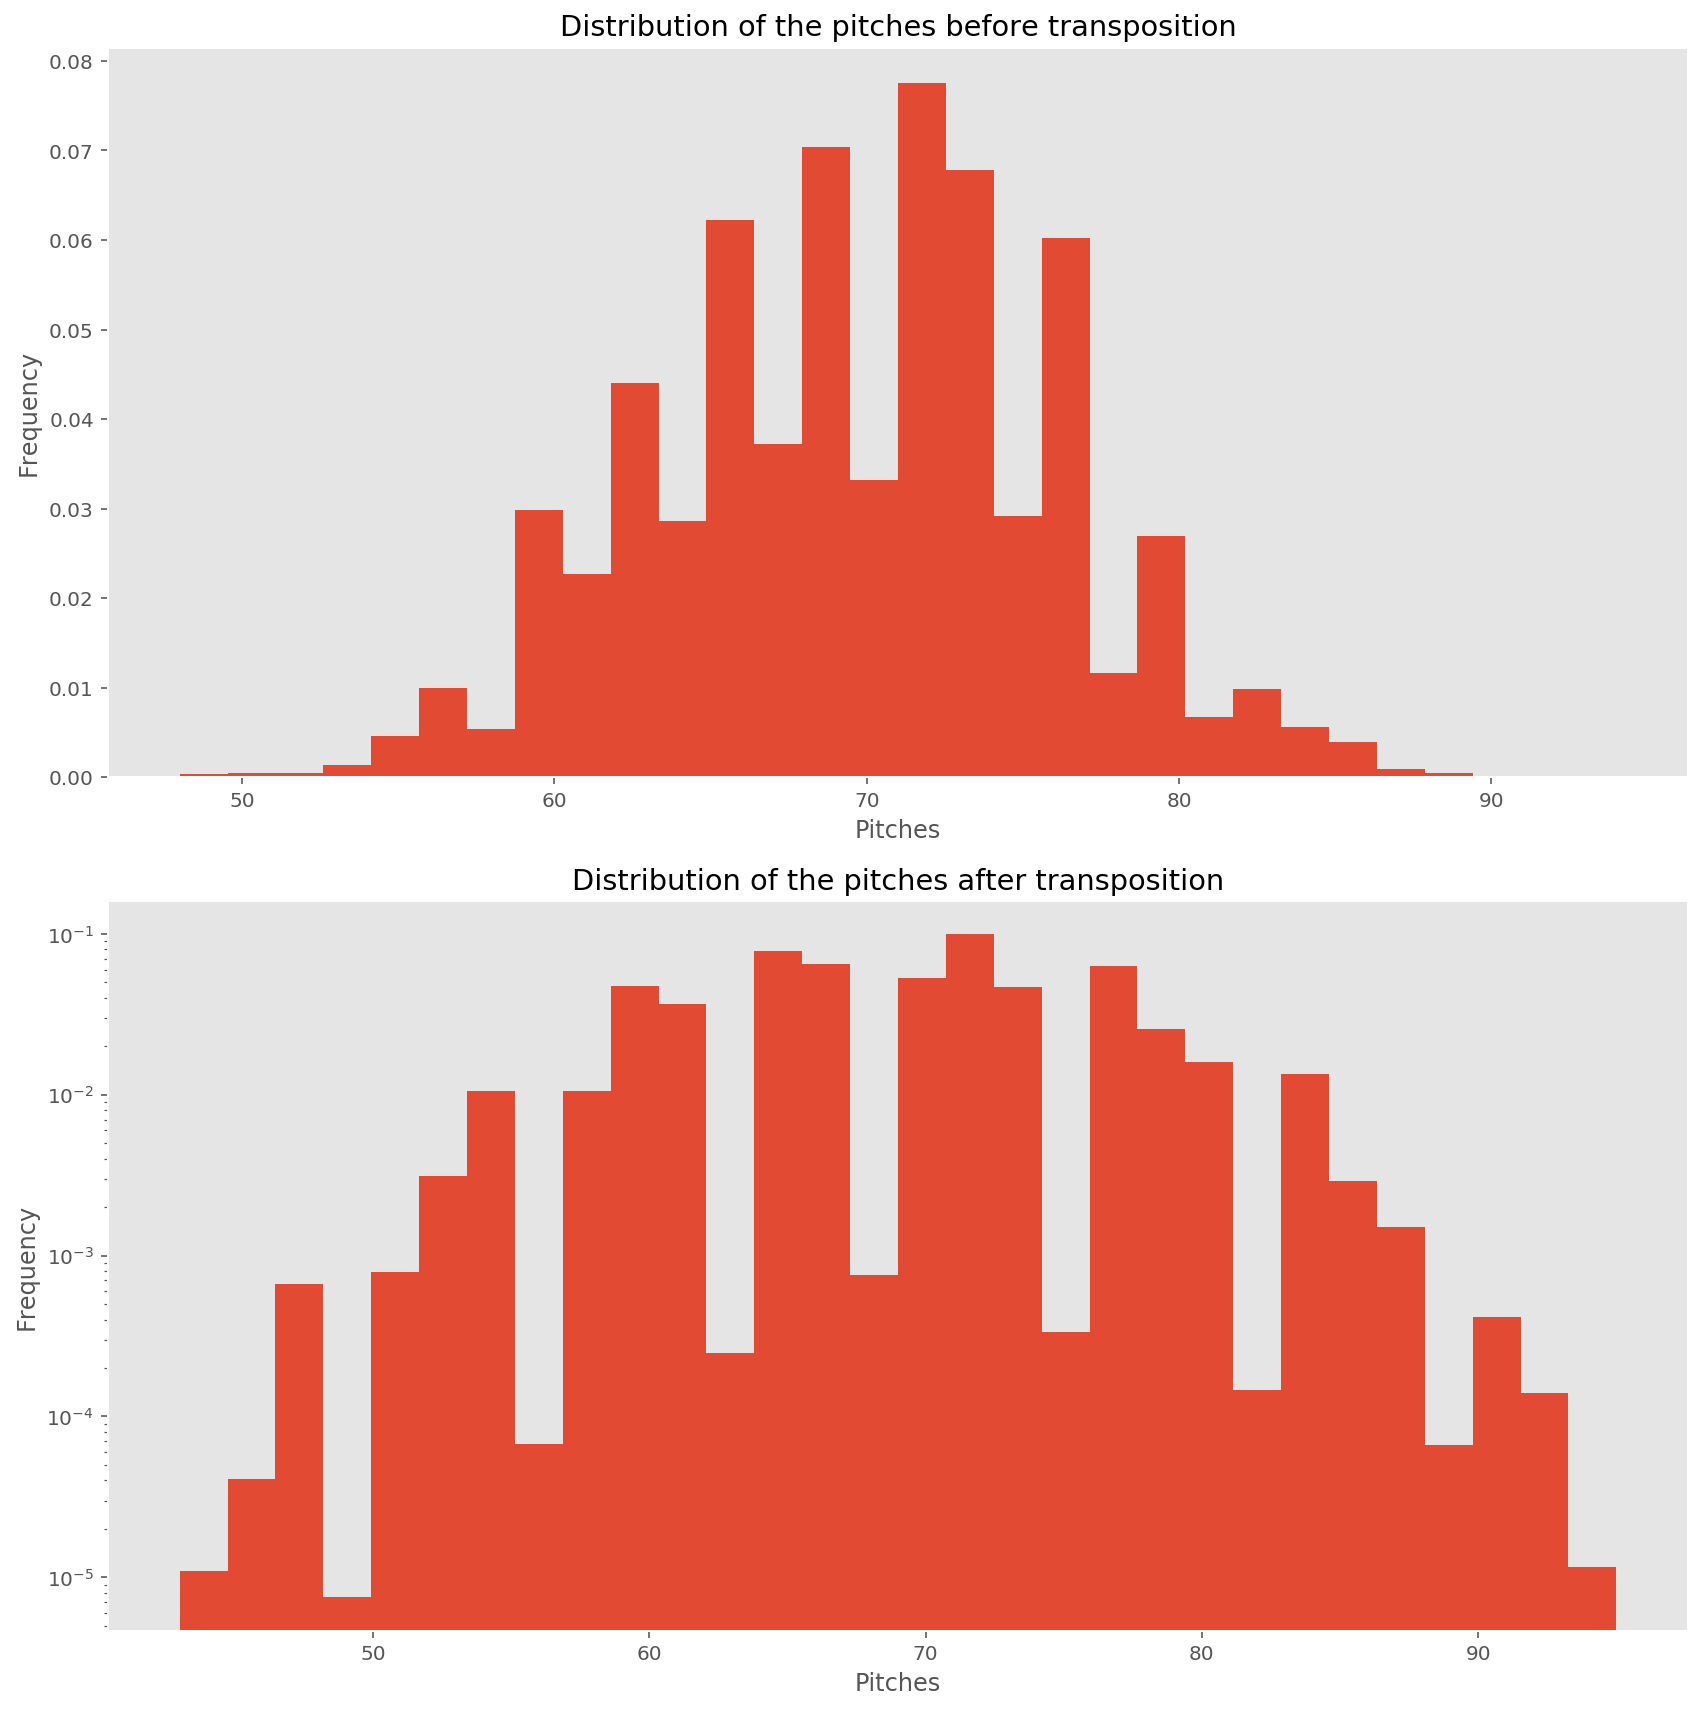

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

ax[0].hist(pitches_before, bins=30, density=True)
ax[0].set_title('Distribution of the pitches before transposition')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Pitches')

ax[1].hist(pitches_after, bins=30, density=True)
ax[1].set_title('Distribution of the pitches after transposition')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Pitches')
ax[1].set_yscale('log', nonposy='clip')

plt.tight_layout()

plt.show()

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: We removed all the durations whose frequencies were below 0.0002549. We found that threshold by taking the largest one such as at most 5% of the melodies are removed. In total, 4.8% were removed. Also, 48 values of durations were concerned out of 65 so only 26% of the durations were kept. It seems like a large majority of durations are very rare. The training time is reduced because the data set is ~5% smaller and the labels are fewer and we can expect the model to learn features better : it couldn't have learnt much from very rare events because of the lack of data containing them.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: For transposition to a single tonality, transposition invariance is learned by "lying" to the model and making him think there is only one tonality. For transposition to all possible tonalities, transposition invariance yields by data augmentation.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represention of a note duration and pitch (vs separating the two features)? 

**Answer**: The number of dimensions would be much higher if we had kept the joint representation (duration, pitch). Considering that all combinations are possible, there would be $17 \times 51 = 867$ dimensions. All of them are probably not present in the data set but this order of magnitude remains. By separating the two features, we only have two representations, one of dimension 17 and the other one of dimension 51.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: 

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

**One-hot encode**

We can use the function `to_categorical` from `keras.utils`. We also recompute the tokenized data set and the dictionaries object with the `tokenize` function defined previously.

In [27]:
from keras.utils import to_categorical

In [28]:
tokenized_dataset, dictionaries = tokenize(transposed_dataset)

num_pitches = len(dictionaries['P'])
num_durations = len(dictionaries['T'])
print('There are {0} pitches and {1} durations in total.'.format(num_pitches, num_durations))

There are 51 pitches and 17 durations in total.


In [29]:
one_hot_dataset_P = []
dims_P = []
one_hot_dataset_T = []
dims_T = []

for label in tokenized_dataset.keys():
    mat_P = to_categorical(tokenized_dataset[label]['P'], num_classes=num_pitches)
    dims_P.append(mat_P.shape[0])
    one_hot_dataset_P.append(mat_P)
    mat_T = to_categorical(tokenized_dataset[label]['T'], num_classes=num_durations)
    dims_T.append(mat_T.shape[0])
    one_hot_dataset_T.append(mat_T)

**Zero-padding**

**1.** We extend here each melody matrices with vectors of zeros.

In [30]:
# max_len_P and max_len_T are obviously equal
max_len_P = int(np.mean(dims_P) + 2*np.std(dims_P))
max_len_T = int(np.mean(dims_T) + 2*np.std(dims_T))

one_hot_dataset_P = pad_sequences(one_hot_dataset_P, maxlen=max_len_P, padding='post', truncating='post')
one_hot_dataset_T = pad_sequences(one_hot_dataset_T, maxlen=max_len_T, padding='post', truncating='post')

**2.** Let's check if the results are coherent.

In [31]:
print('Dimensions of the resulting tensors are', one_hot_dataset_P.shape, ' for pitches and', one_hot_dataset_T.shape, ' for durations.')

Dimensions of the resulting tensors are (4400, 384, 51)  for pitches and (4400, 384, 17)  for durations.


sessiontune30877 before one hot encoding and zero padding


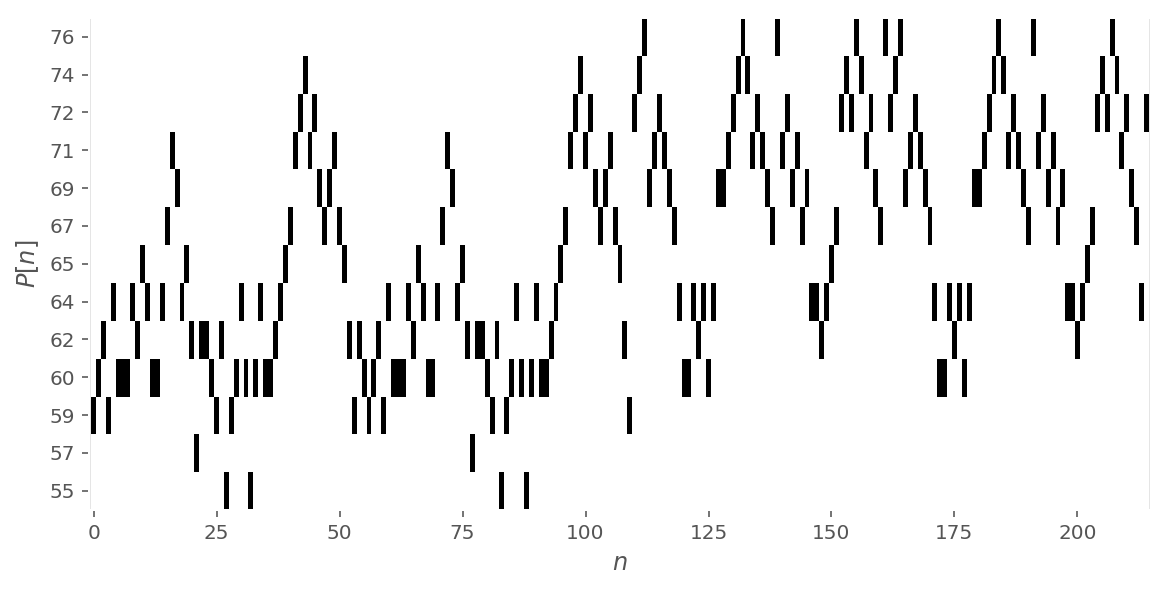

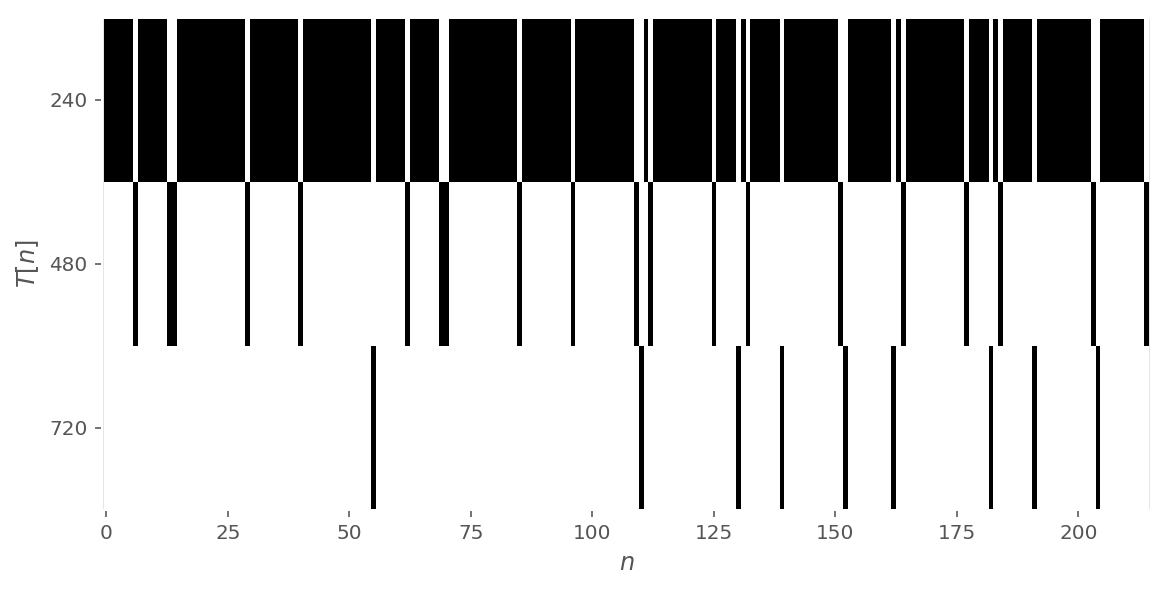

sessiontune30877 after one hot encoding and zero padding


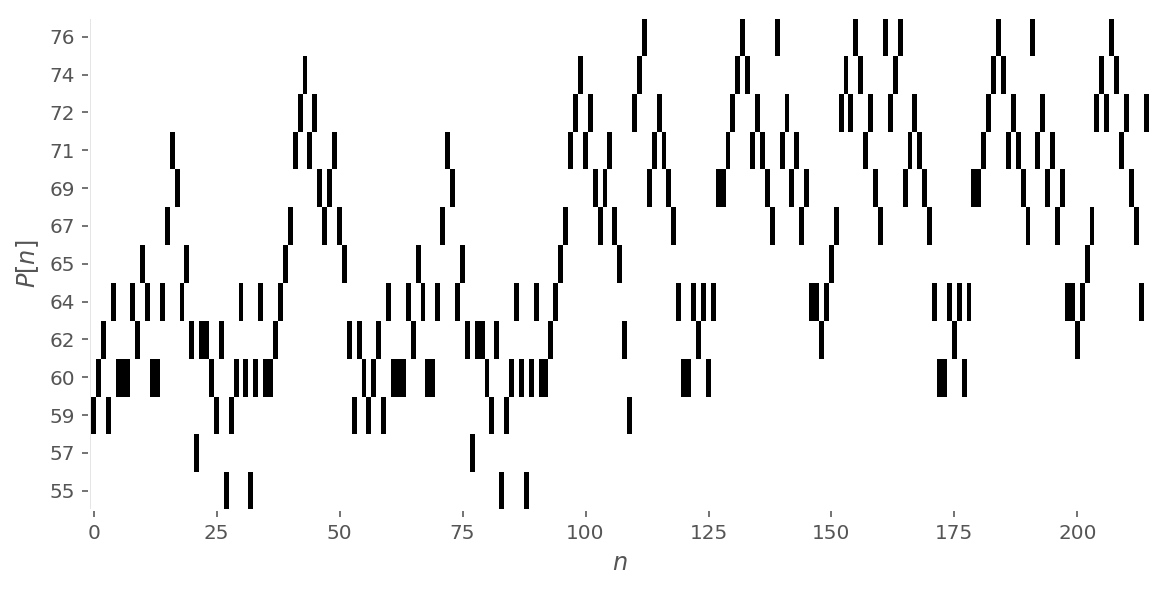

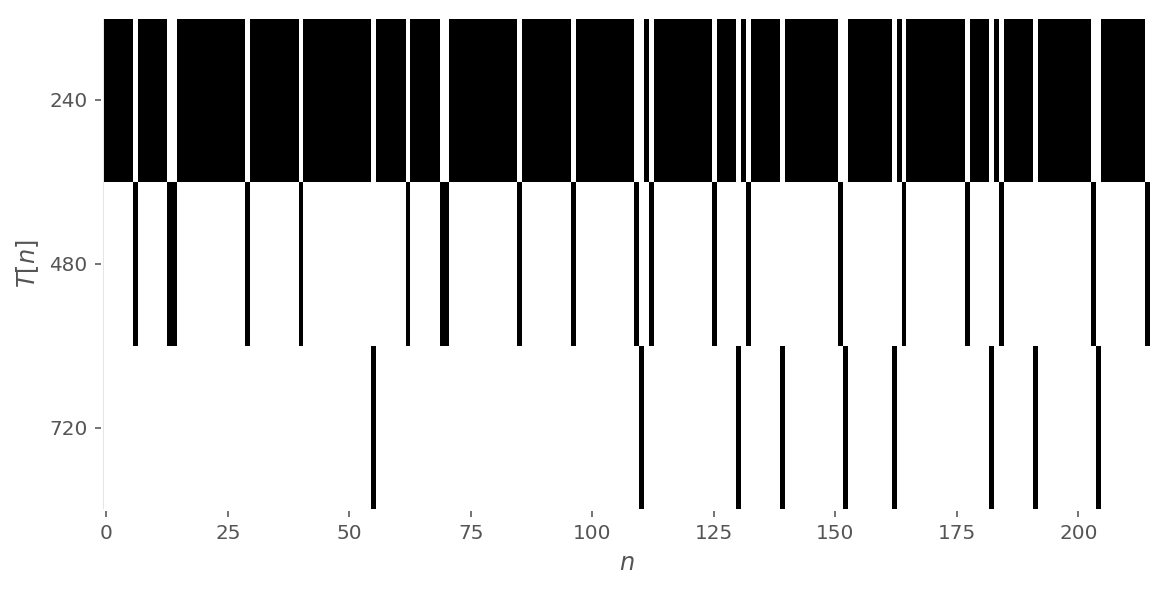

sessiontune43015 before one hot encoding and zero padding


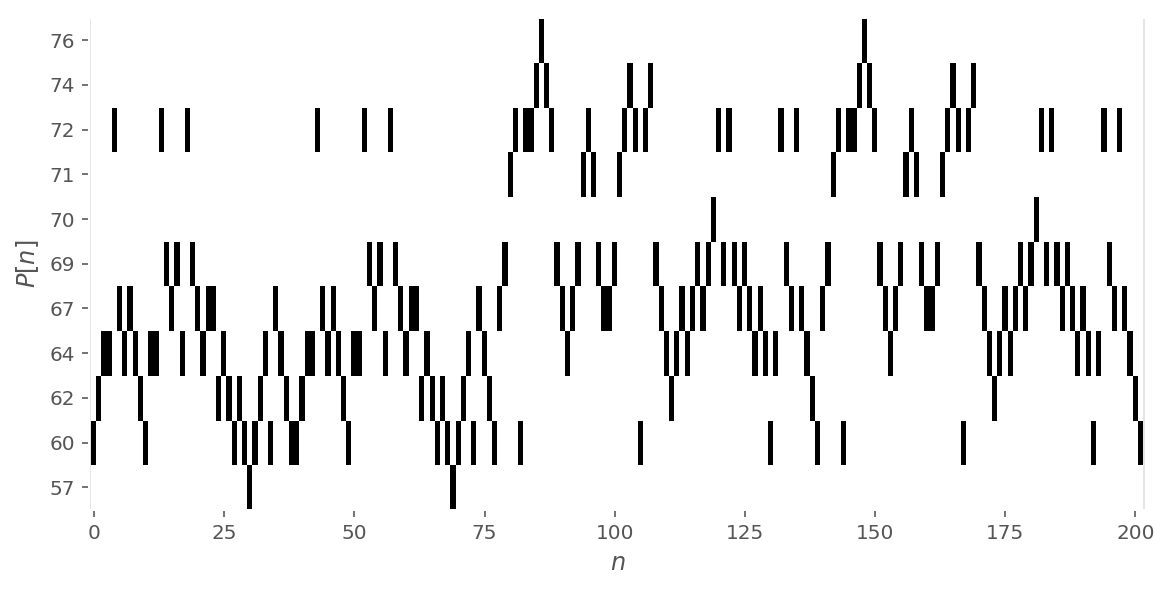

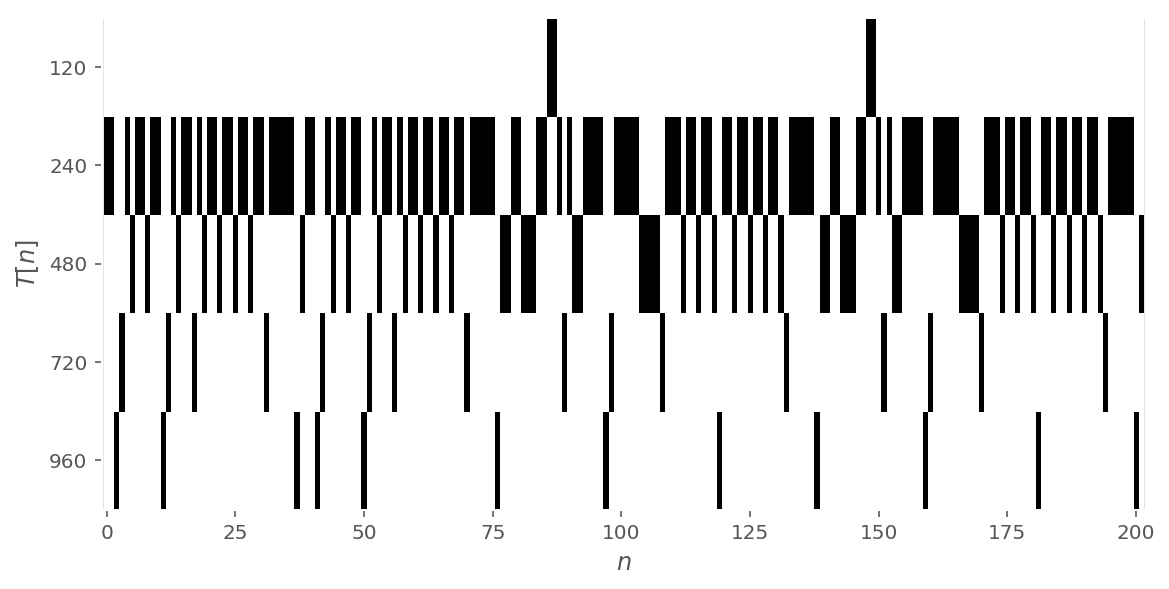

sessiontune43015 after one hot encoding and zero padding


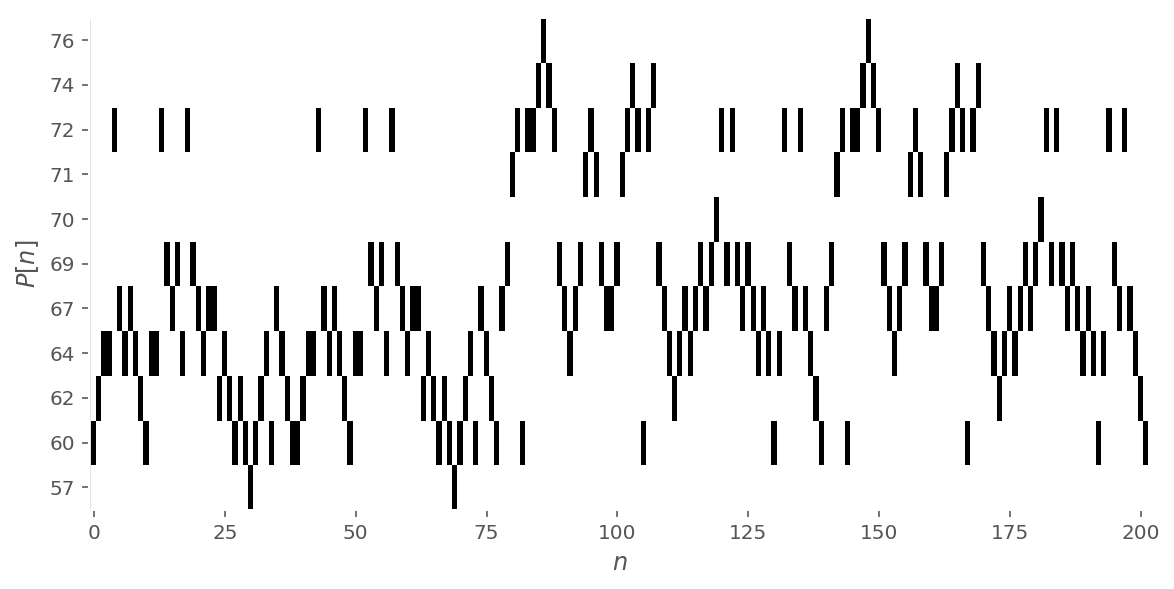

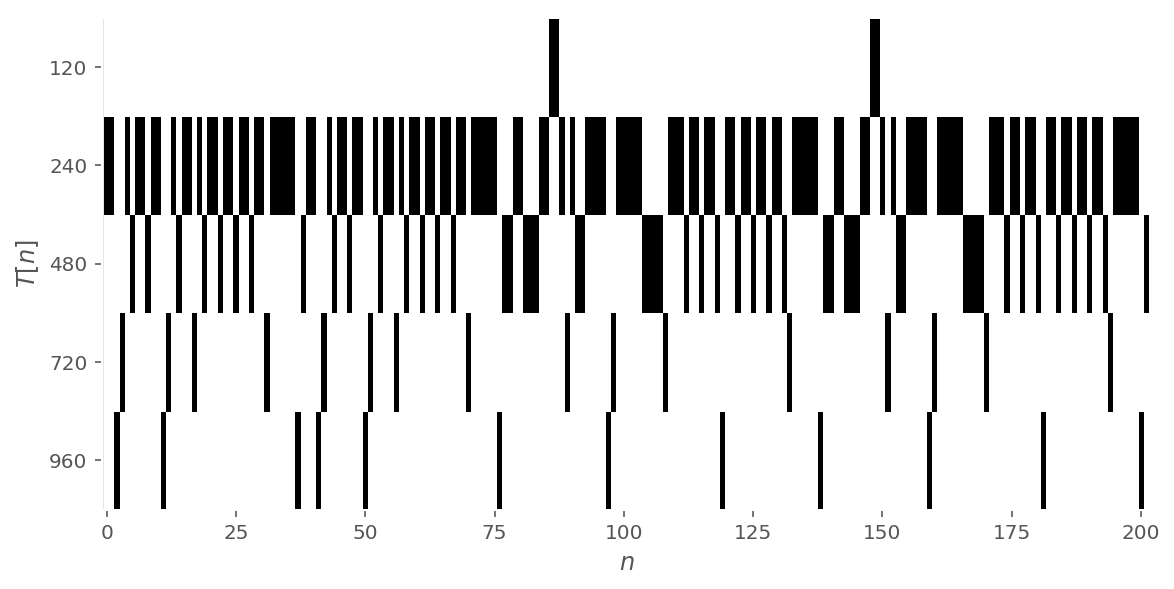

In [32]:
for label in np.random.choice(list(tokenized_dataset.keys()), 2):
    #print(list(filter_token_dataset.keys()).index(label))
    print(label ,'before one hot encoding and zero padding')
    plotMelody(tokenized_dataset[label]['P'], tokenized_dataset[label]['T'], dictionaries)
    print(label ,'after one hot encoding and zero padding')
    plotMelody(one_hot_dataset_P[list(tokenized_dataset.keys()).index(label)], one_hot_dataset_T[list(tokenized_dataset.keys()).index(label)], dictionaries)

It seems that we have same plots !

Finally, we save here the variables `one_hot_dataset_P`, `one_hot_dataset_T` and `dictionaries` so we don't have to recompute them.

In [33]:
"""
Saving the lists. /!\ Do not run it unless you want to override them.
"""
save_obj(one_hot_dataset_P, 'one_hot_dataset_P')
save_obj(one_hot_dataset_T, 'one_hot_dataset_T')
save_obj(dictionaries, 'dictionaries')

In [4]:
"""
Loading the lists.
"""
one_hot_dataset_P = load_obj('one_hot_dataset_P')
one_hot_dataset_T = load_obj('one_hot_dataset_T')
dictionaries = load_obj('dictionaries')

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [17]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0, name="MT")(X['T'])
    M['P'] = Masking(mask_value=0, name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(units=Hsize, dropout=dropout, return_sequences=True, name='Hidden')(H['1'])
    elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        H['2'] = LSTM(Hsize, dropout=dropout, return_sequences=True, name='Hidden')(H['1'])
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(units=Hsize, dropout=dropout, return_sequences=True, name='Hidden')(H['1'])

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])  # Input(s) to duration output layer)
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])  # Input(s) to pitch output layer)
    
    model = Model(inputs = [X['T'], X['P']], outputs=[Y['T'], Y['P']])
    opt = Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
    
    return model

The following `early_stopping` function artificially simulate an early stopping by keeping the loss and the accuracy from the epoch where the validation loss is minimal. Since there are two validation losses, we minimize the sum of them (which is equivalent to minimize the average of them).

In [6]:
def early_stopping(history):
    index = np.argmin(np.array(history['val_YP_loss']) + np.array(history['val_YT_loss']))
    print('The validation YT loss is {}.'.format(history['val_YT_loss'][index]))
    print('The validation YP loss is {}.'.format(history['val_YP_loss'][index]))
    print('The validation YT accuracy is {}.'.format(history['val_YT_acc'][index]))
    print('The validation YP accuracy is {}.'.format(history['val_YP_acc'][index]))

The following `shift_data` function is used to create the training data and the training targets (for durations and pitches). Since the model has to predict the next duration and pitch, the data has to be shifted in the second dimension.

In [7]:
def shift_data(one_hot_dataset_T, one_hot_dataset_P):
    return one_hot_dataset_T[:, :-1, :], one_hot_dataset_P[:, :-1, :], one_hot_dataset_T[:, 1:, :], one_hot_dataset_P[:, 1:, :]

data_T, data_P, targets_T, targets_P = shift_data(one_hot_dataset_T, one_hot_dataset_P)

batch_length = one_hot_dataset_P.shape[1] - 1

**1.** We train here the RNN model composed of a SimpleRNN layer.

In [18]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=batch_length,  # Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')
RNNmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 383, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 383, 51)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 383, 17)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 383, 51)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

The `ModelCheckpoint` checkpoint object allows us to save a different version of the model each time the `val_loss` reachs a new minimum.

In [9]:
history_rnn = RNNmodel.fit([data_T, data_P],
                           [targets_T, targets_P],
                           batch_size=32,
                           epochs=300,
                           validation_split=0.2,
                           verbose=0,
                           callbacks=[ModelCheckpoint('data2/rnn/rnn.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)])

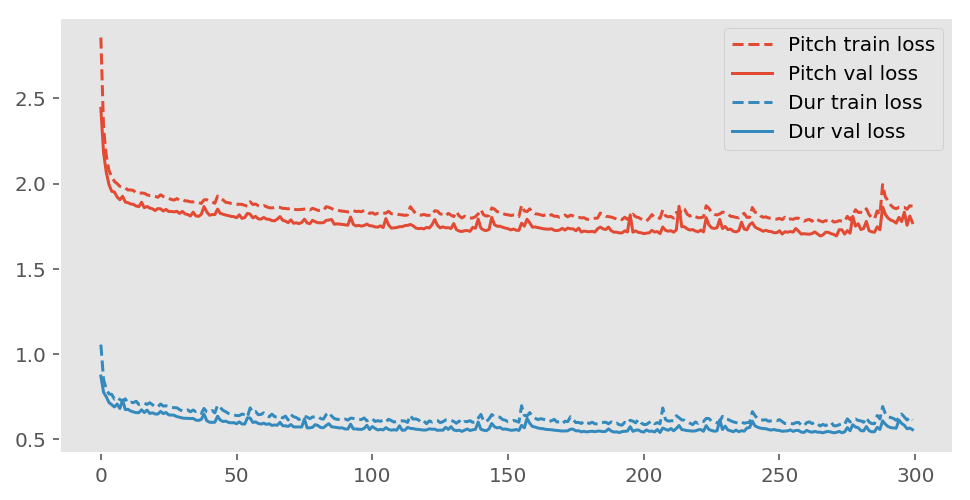

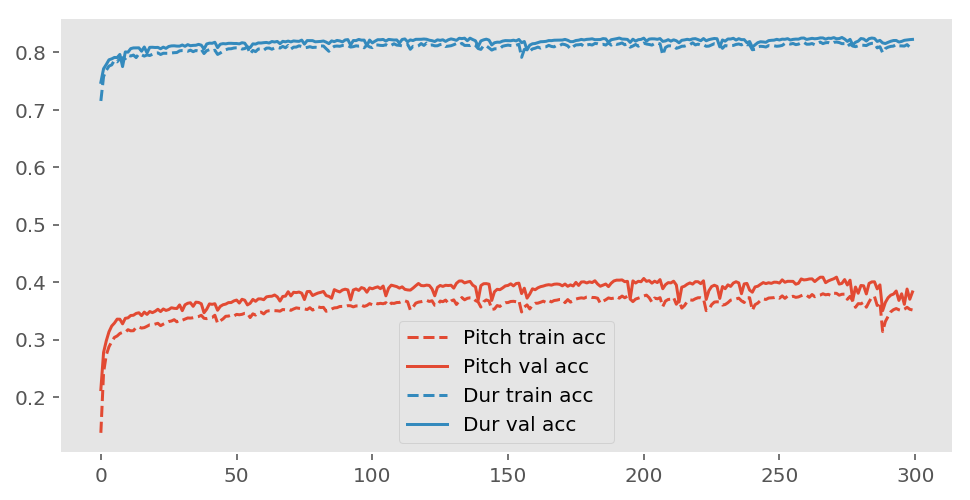

In [10]:
plotLearningCurves(history_rnn)

We finally save the history in `history_rnn` with the `save_obj` described above.

In [11]:
save_obj(history_rnn.history, 'history_rnn')

In [12]:
history_rnn = load_obj('history_rnn')
early_stopping(history_rnn)

The validation YT loss is 0.5405522108078002.
The validation YP loss is 1.6931684537367386.
The validation YT accuracy is 0.8237901839342985.
The validation YP accuracy is 0.40880526358431035.


**2.** We train now the GRU model with the same hyper-parameters in order to compare it to the previous model.

In [19]:
GRUmodel = buildModel(dictionaries,
                      batch_length=one_hot_dataset_P.shape[1] - 1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')
GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 383, 17)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 383, 51)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 383, 17)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 383, 51)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [14]:
history_gru = GRUmodel.fit([data_T, data_P],
                           [targets_T, targets_P],
                           batch_size=32,
                           epochs=300,
                           validation_split=0.2,
                           verbose=0,
                           callbacks=[ModelCheckpoint('data2/gru/gru.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)])

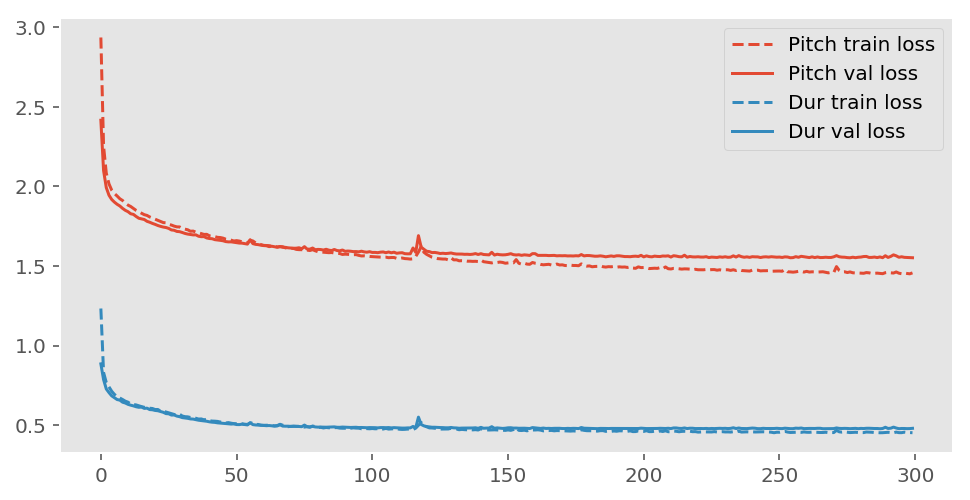

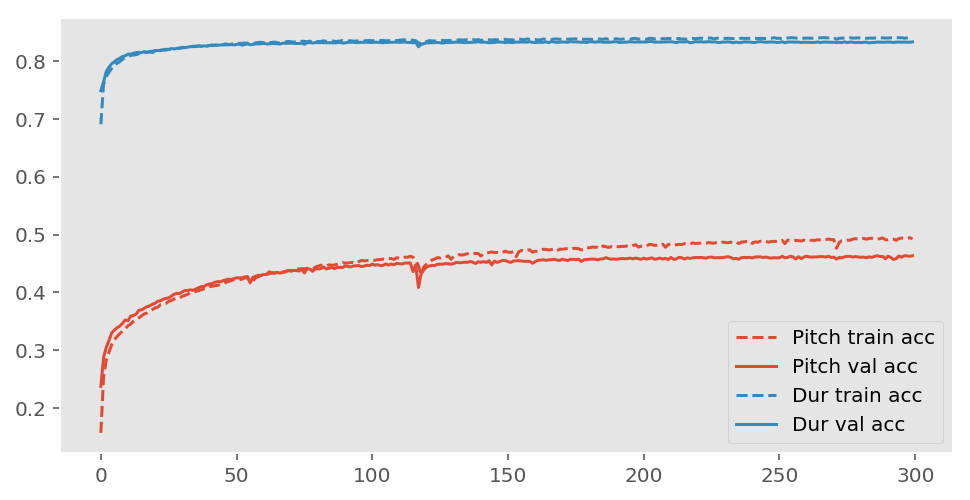

In [15]:
plotLearningCurves(history_gru)

In [16]:
save_obj(history_gru.history, 'history_gru')

In [17]:
history_gru = load_obj('history_gru')
early_stopping(history_gru)

The validation YT loss is 0.4784037676724521.
The validation YP loss is 1.5520570798353714.
The validation YT accuracy is 0.832830711928281.
The validation YP accuracy is 0.46235185807401485.


**3.** On a single plot, adapt the plotLearningCurves(History) function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.

In [19]:
def compareLearningCurves(history_rnn, history_gru, toplot='loss'):
    try:
        history_rnn = history_rnn.history
        history_gru = history_gru.history
    except:
        pass
    plt.figure(figsize=(8,4))
    plt.plot(history_rnn['val_YP_' + toplot], c=c[0], label='RNN pitch val ' + toplot)
    plt.plot(history_gru['val_YP_' + toplot], c=c[1], label='GRU pitch val ' + toplot)
    
    plt.plot(history_rnn['val_YT_' + toplot], '--', c=c[0], label='RNN dur val ' + toplot)
    plt.plot(history_gru['val_YT_' + toplot], '--', c=c[1], label='GRU dur val ' + toplot)
    plt.legend(loc='best')

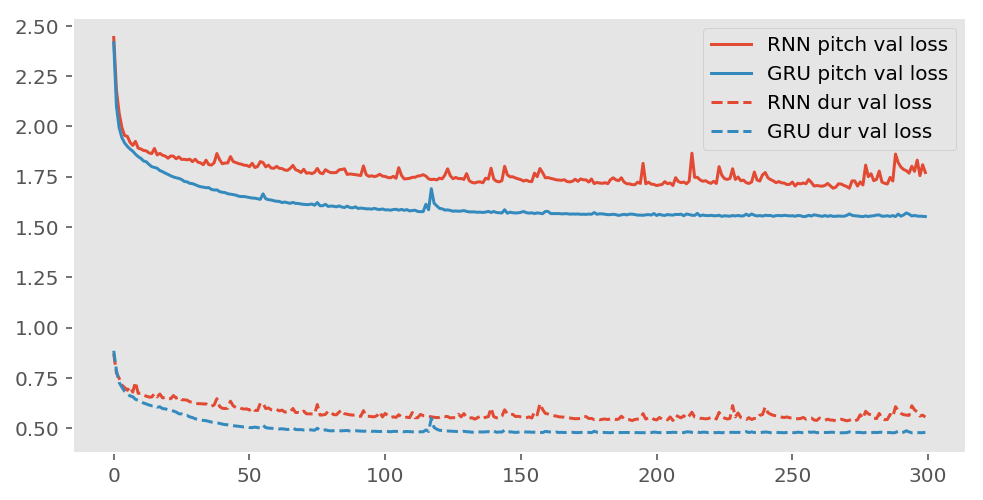

In [20]:
compareLearningCurves(history_rnn, history_gru, toplot='loss')

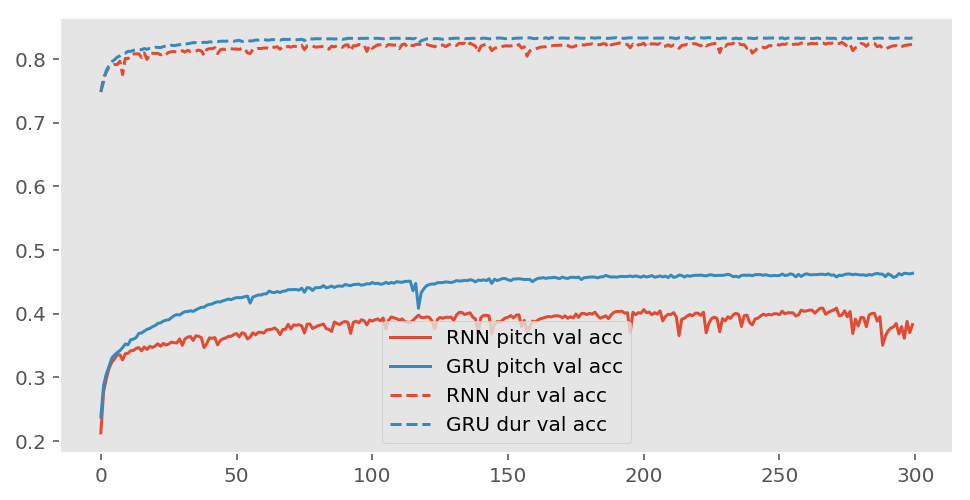

In [21]:
compareLearningCurves(history_rnn, history_gru, toplot='acc')

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: Here is a table summarizing the results obtained :

| Model | Accuracy T | Accuracy P |
| ----- |:----------:|:----------:|
| RNN   | 0.8237     | 0.4088     |
| GRU   | 0.8328     | 0.4623     |

The GRU model is better for both the durations and the pitches accuracies. For the pitches it is significantly better than the RNN. We could expect that the GRU would perform better considering that it has a more sophisticated structure (gating ability) and more parameters (84,420 against 33,988).
We notice that the accuracies for the durations are very high (around 82%) compared to the accuracies for the pitches (in the range 40-46%). It actually makes sense because we can expect the rythm of the music to be easier to predict than the pitches, which tend to be less regular.


**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation functions.
    
**Answer**: From the learning curves it is clear that the GRU model performs better than the RNN one : the validation accuracies and losses are better all along the training.
It also appears that both models learn very quickly during the first epochs of the training and the curves rapidly become flat. It is especially true for the durations, whose curves seem flat after only 80 epochs.
We finally notice that the curves of the RNN training have more irregularities than the GRU training, which is smoother. Once again, it may come from the fact that the GRU model has more parameters and has a gating ability.

## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

**1.** We select here 4 melodies randomly and load the best model : it is the GRU model from the epoch 248.

In [22]:
random_melodies = np.random.choice(np.arange(data_T.shape[0]), 4)

model = buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU')
model.load_weights('data2/gru/gru.277-2.03.hdf5')

Melody #2267. Accuracy T : 0.8949. Accuracy P : 0.4618.


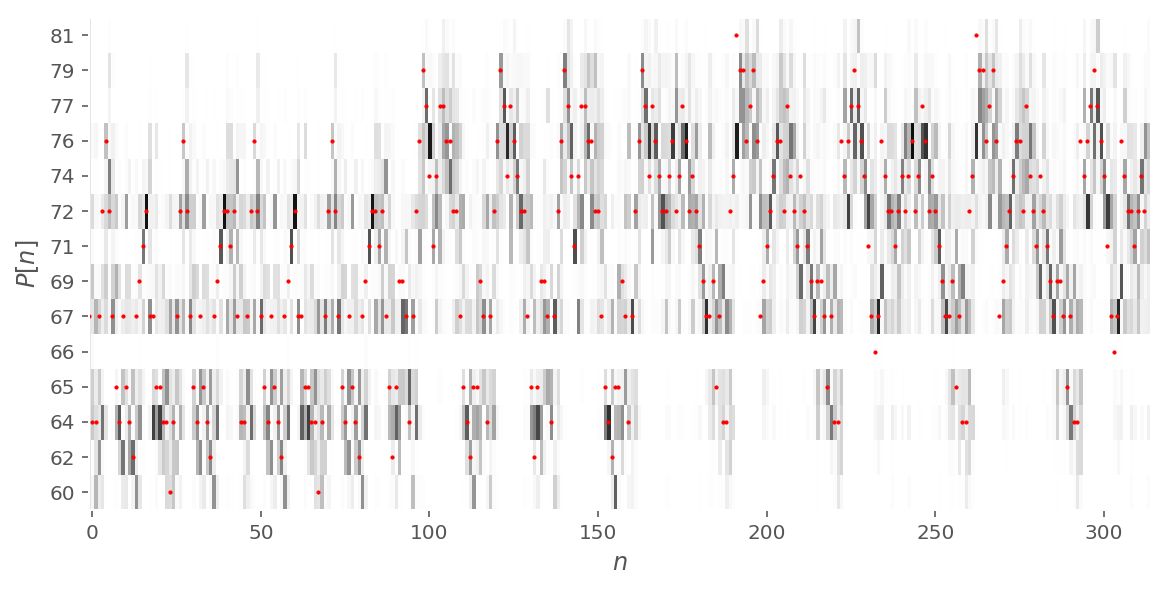

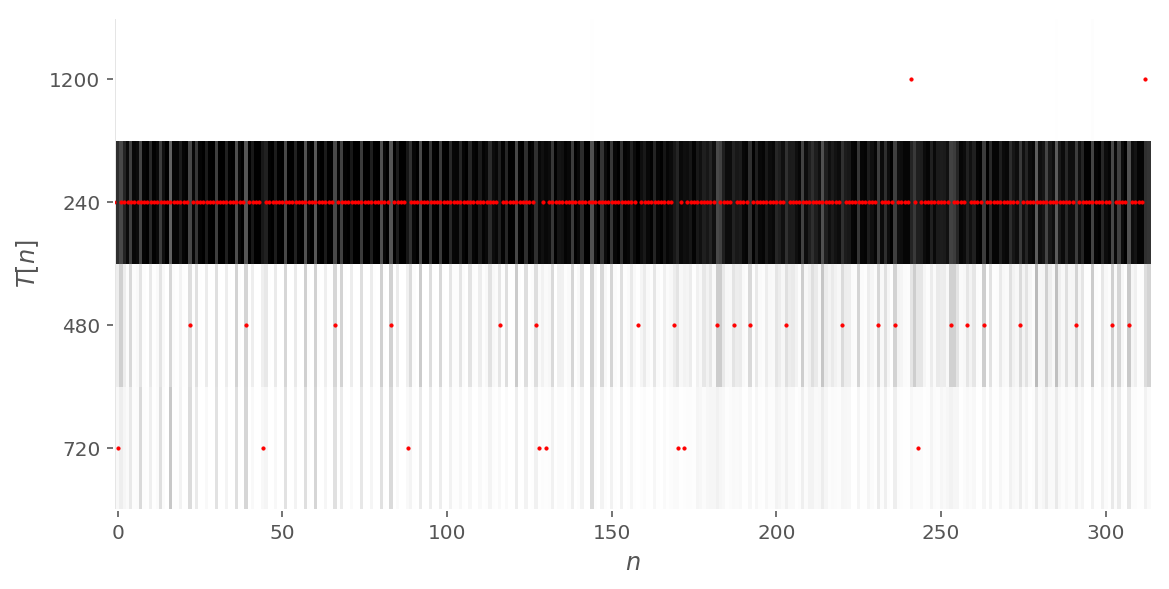

Melody #2319. Accuracy T : 0.7533. Accuracy P : 0.4067.


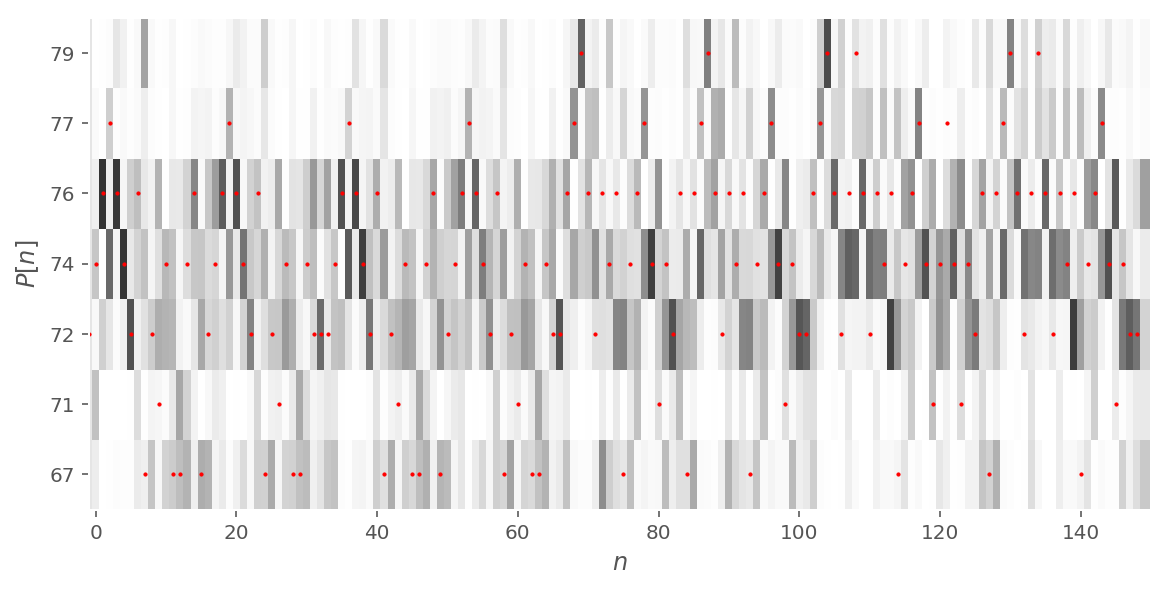

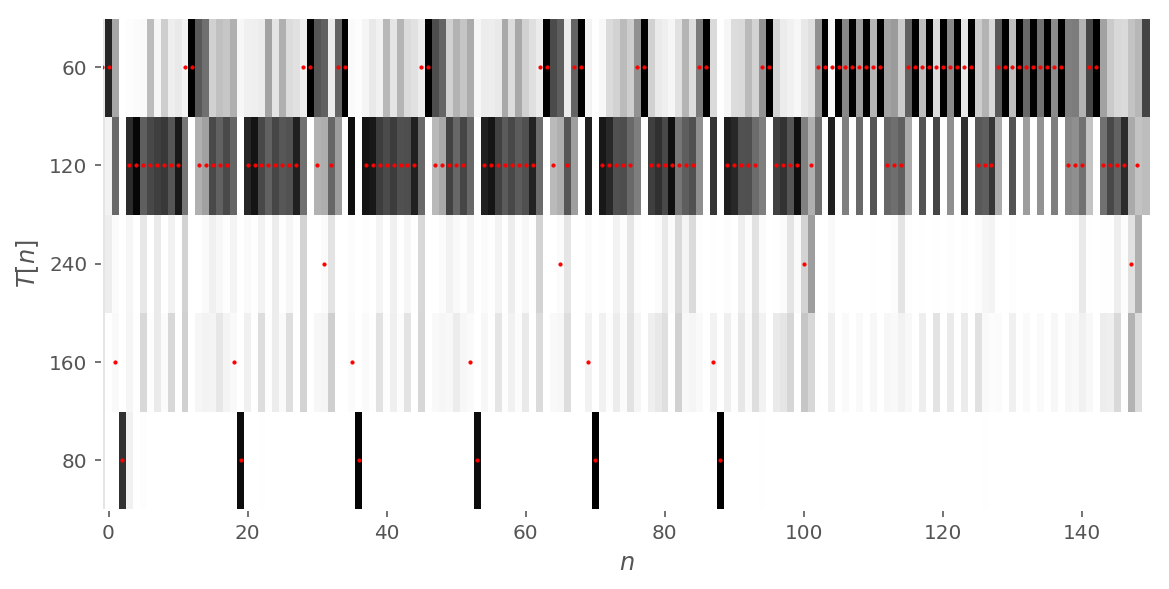

Melody #459. Accuracy T : 0.8769. Accuracy P : 0.5672.


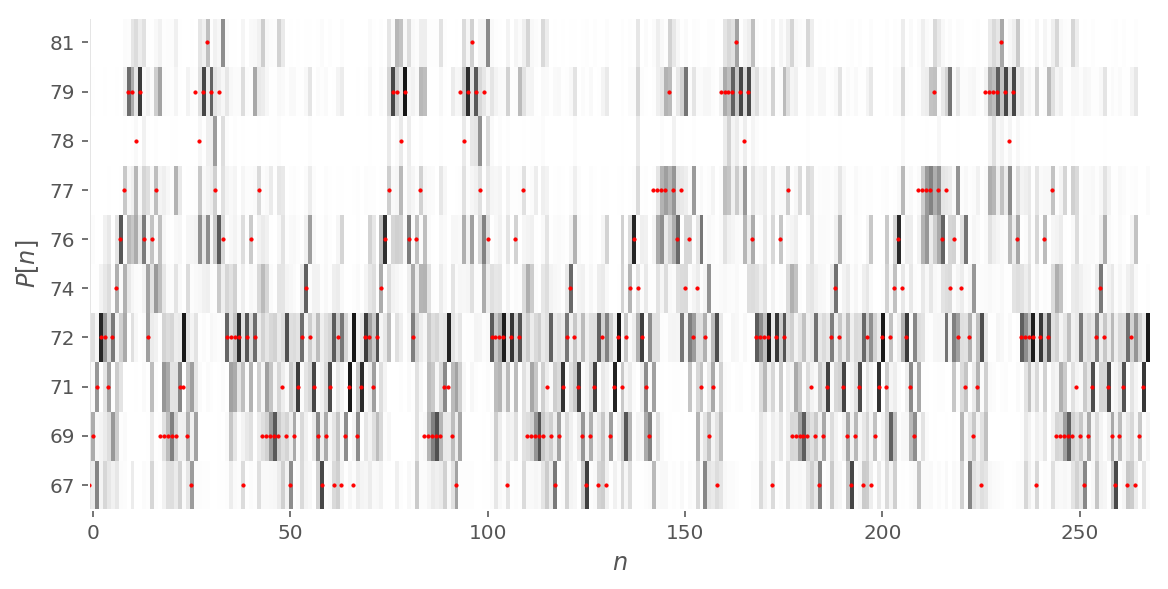

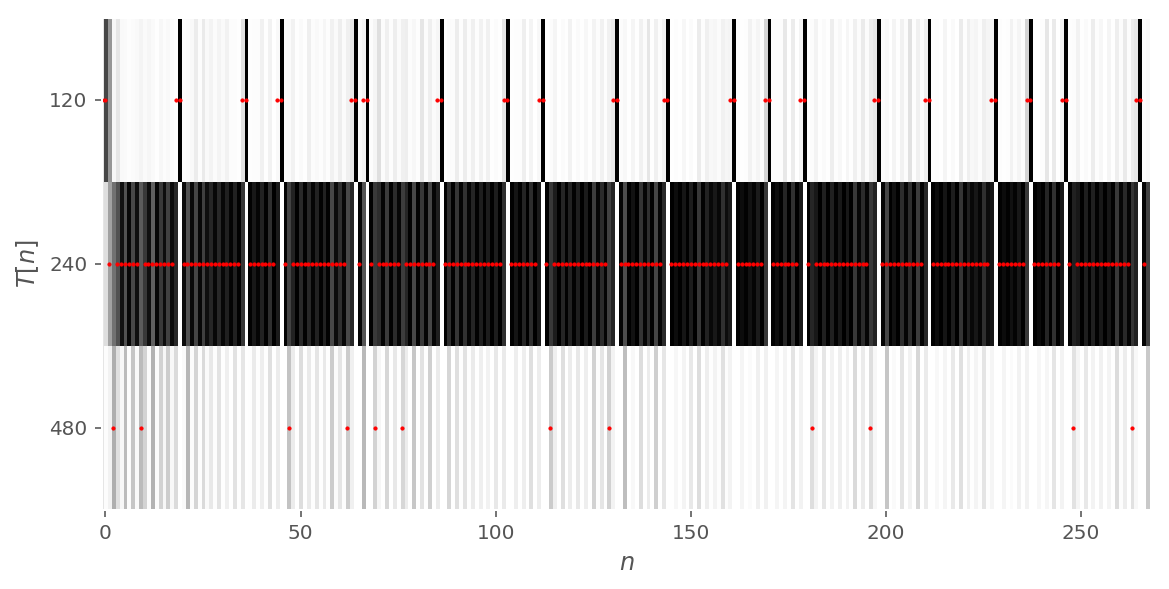

Melody #272. Accuracy T : 0.8882. Accuracy P : 0.5176.


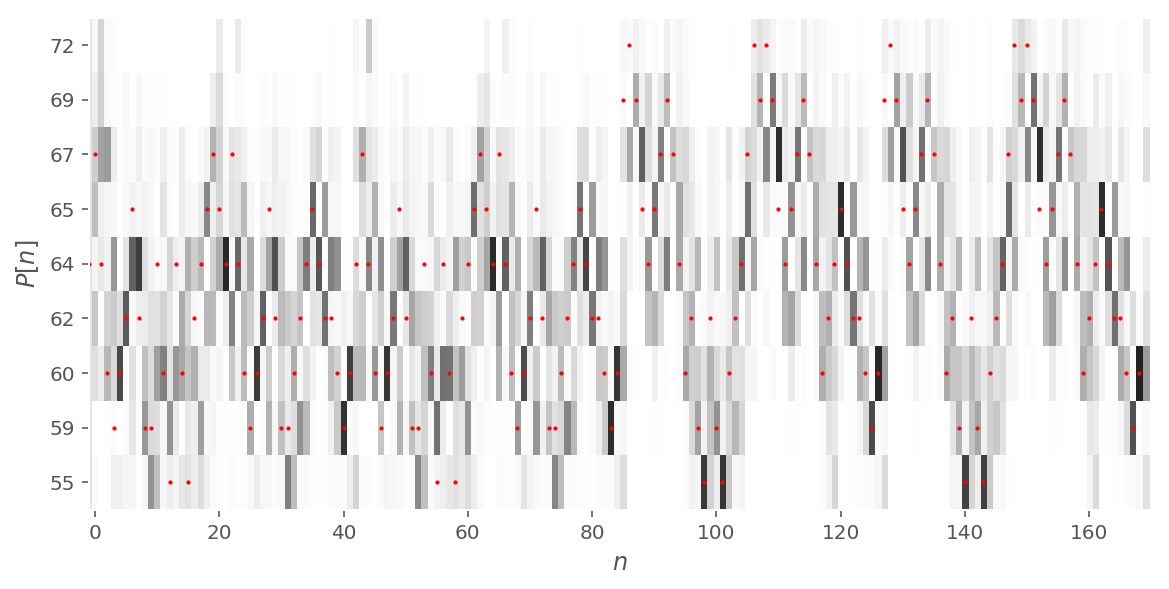

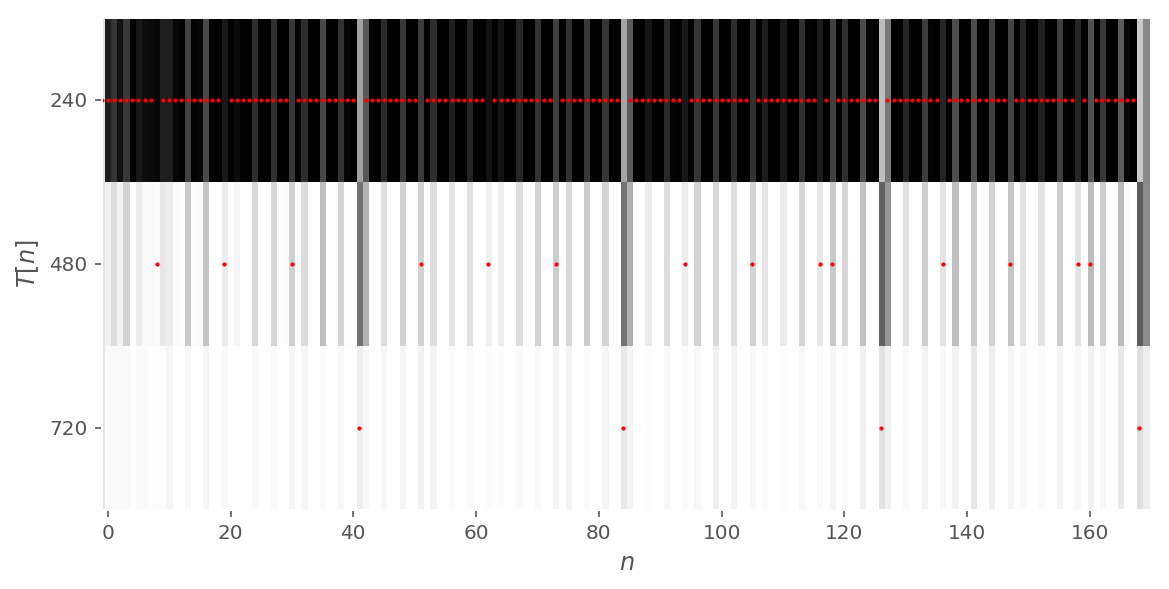

In [23]:
for index, melody in enumerate(random_melodies):
    prediction_T, prediction_P = model.predict([data_T[melody:(melody + 1)],
                                                data_P[melody:(melody + 1)]])
    prediction_T, prediction_P = prediction_T[0], prediction_P[0]
    metrics = model.evaluate([data_T[melody:(melody + 1)],
                              data_P[melody:(melody + 1)]],
                             [targets_T[melody:(melody + 1)],
                              targets_P[melody:(melody + 1)]],
                             verbose=0)
    accuracy_T = metrics[3]
    accuracy_P = metrics[4]
    print('Melody #{0}. Accuracy T : {1}. Accuracy P : {2}.'.format(melody,
                                                                    round(accuracy_T, 4),
                                                                    round(accuracy_P, 4)))
    plotMelody(one_hot_dataset_P[melody], one_hot_dataset_T[melody],
               dictionaries,
               prediction_P, prediction_T)

**2.** We define here the function `build_hidden_state_model` which takes the original model and creates a new one whose output is the output of the reccurent layer (named `'Hidden'` in `build_model`).

In [24]:
def build_hidden_state_model(model):
    recurrent_layer = model.get_layer('Hidden')
    return Model(inputs=model.inputs, outputs=recurrent_layer.output)

hidden_state_model = build_hidden_state_model(model)

In order to get the 2-dimensional matrix representing the hidden state over time, we just have to use the `predict` method with this new model. It will then return the content of the hidden recurrent layer.

Melody #2267. Accuracy T : 0.8949. Accuracy P : 0.4618.


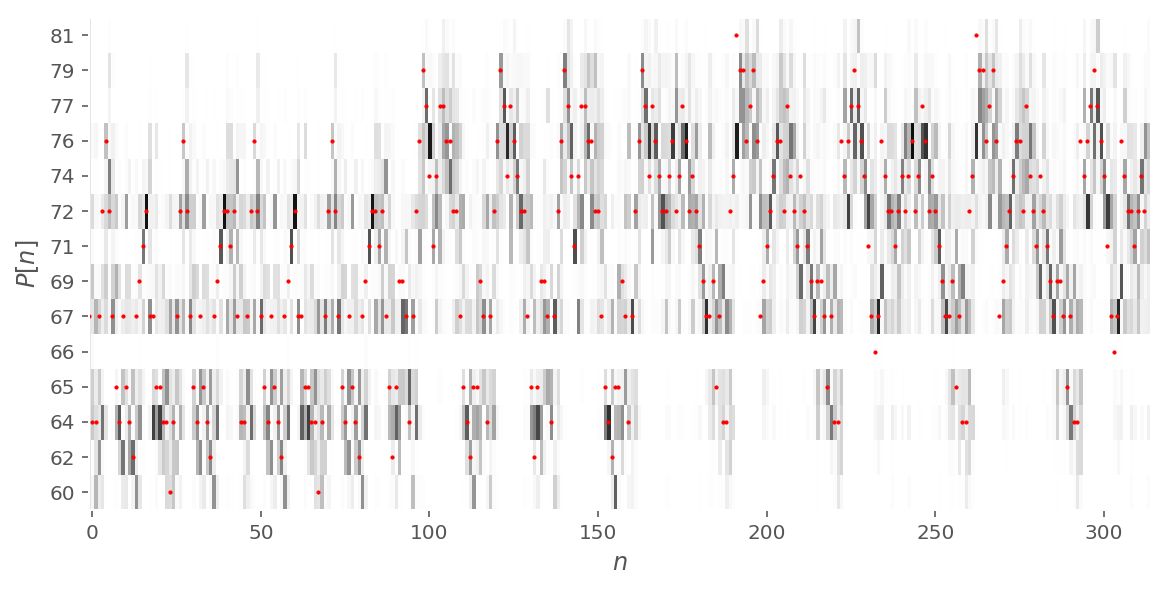

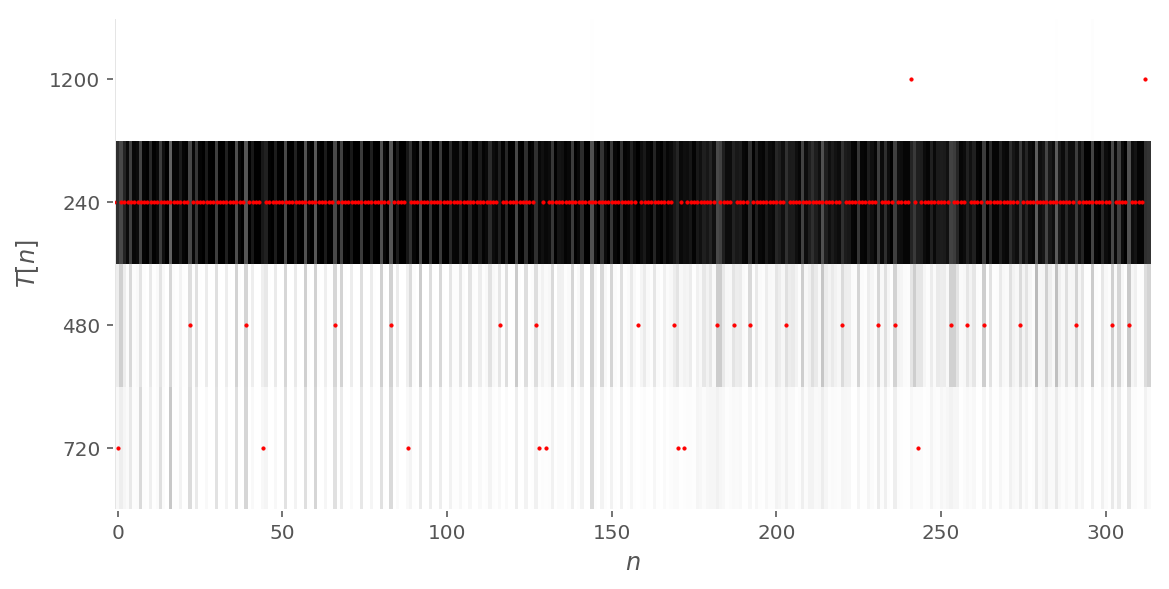

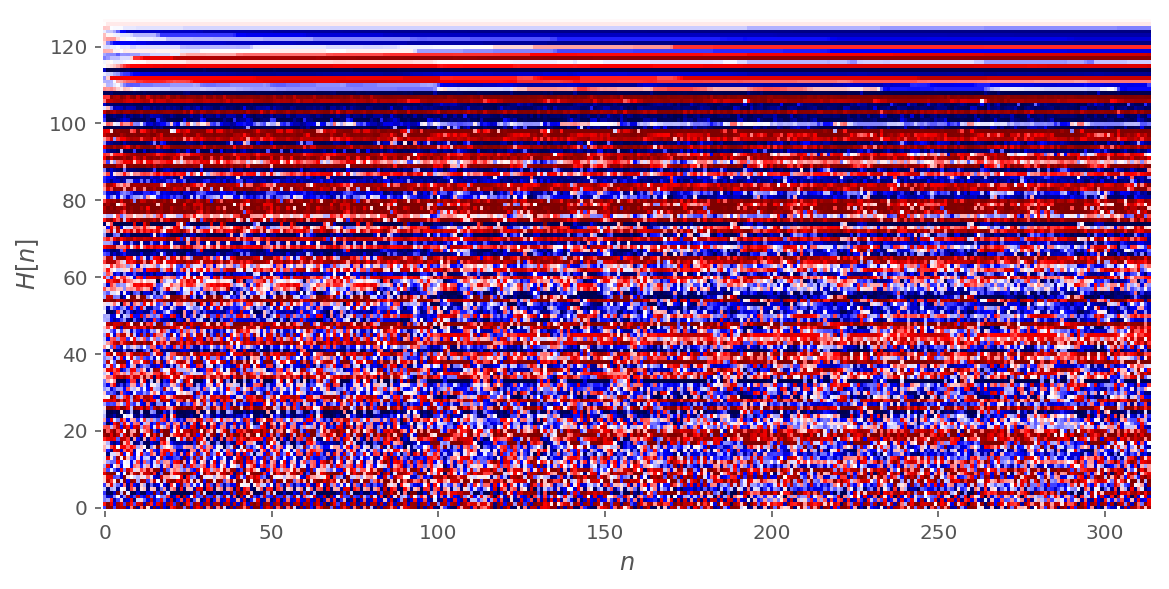

Melody #2319. Accuracy T : 0.7533. Accuracy P : 0.4067.


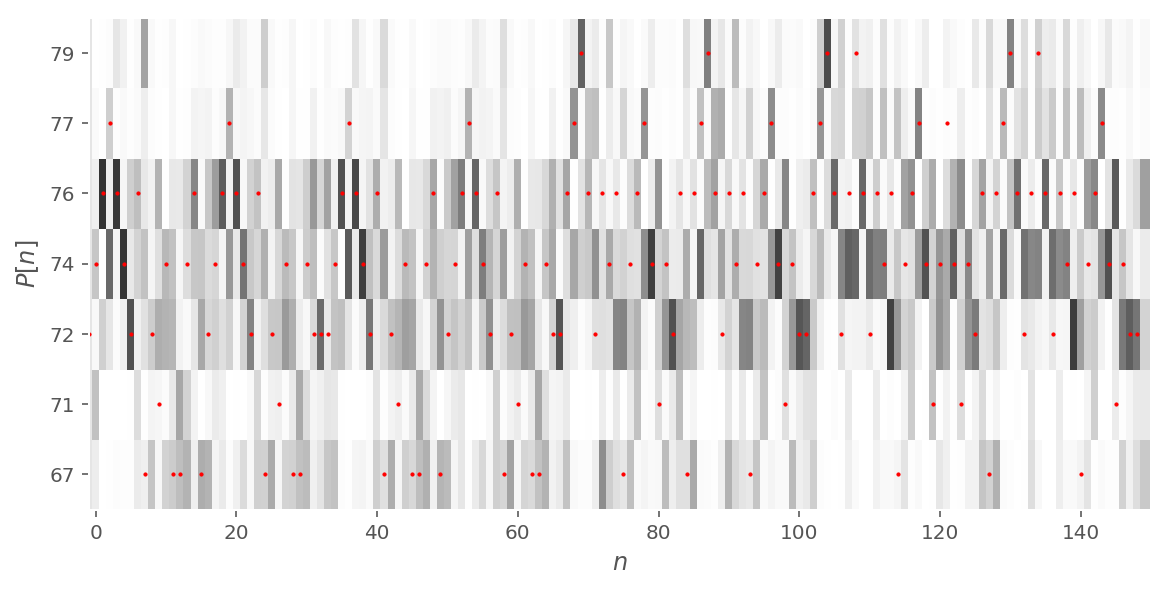

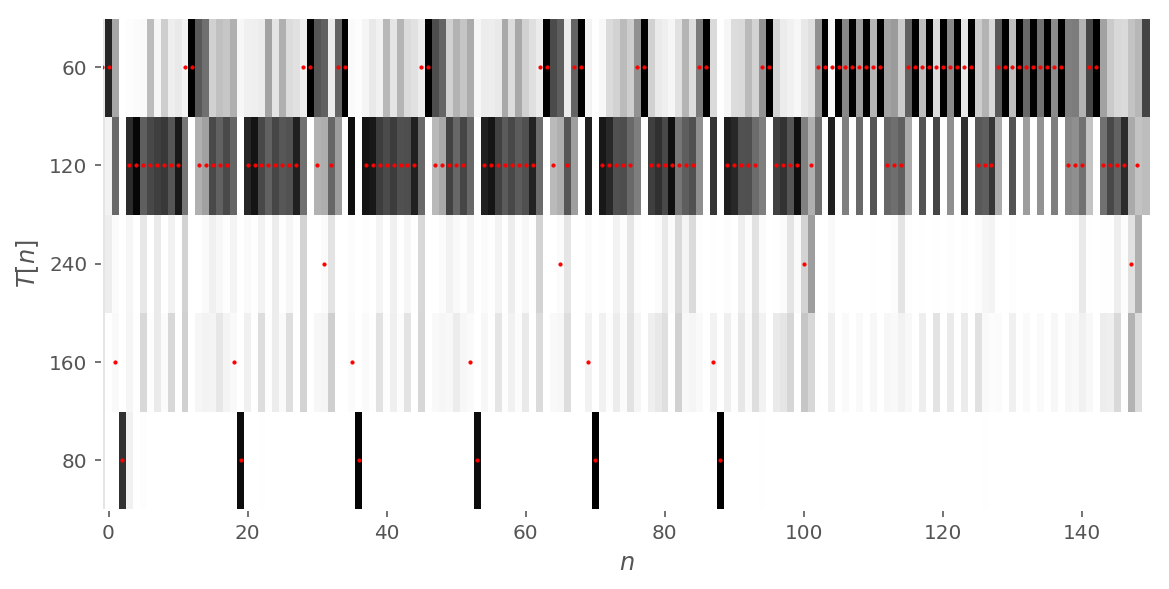

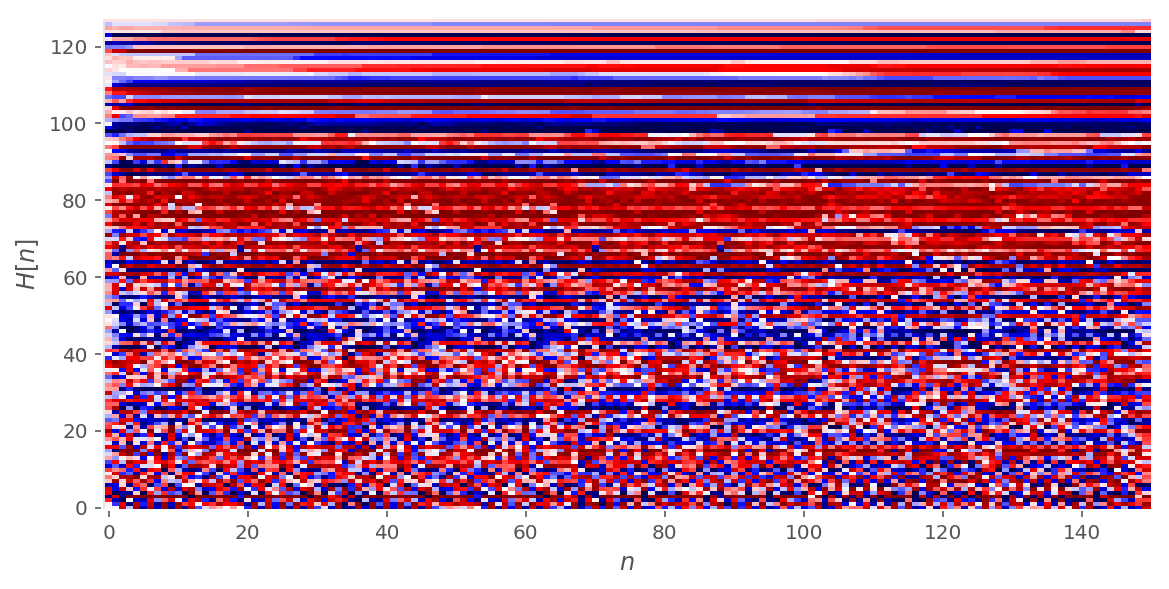

Melody #459. Accuracy T : 0.8769. Accuracy P : 0.5672.


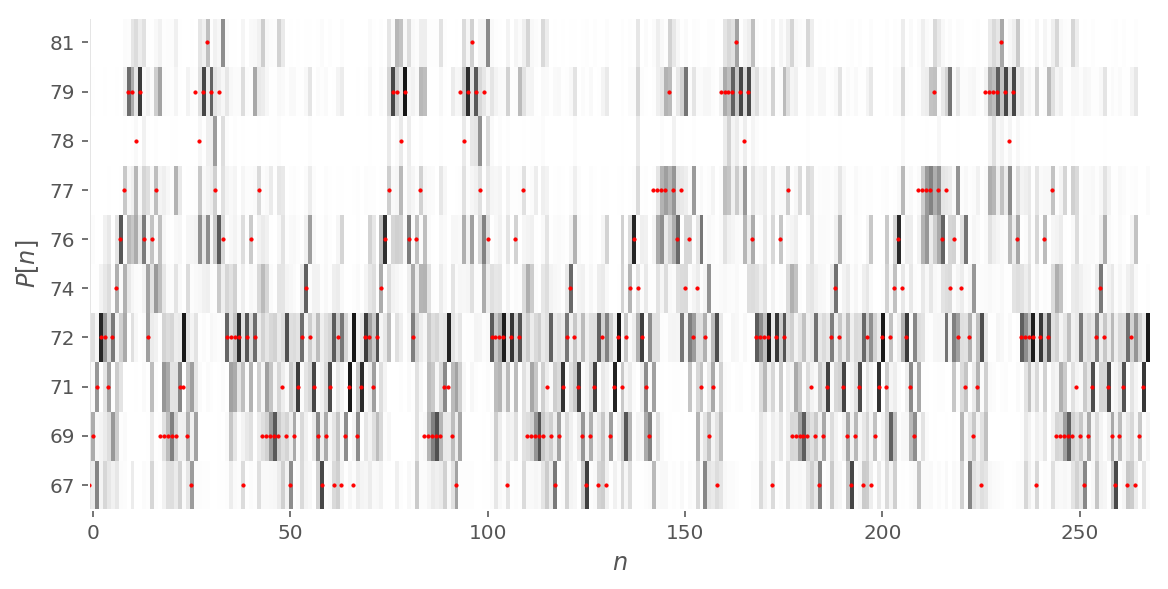

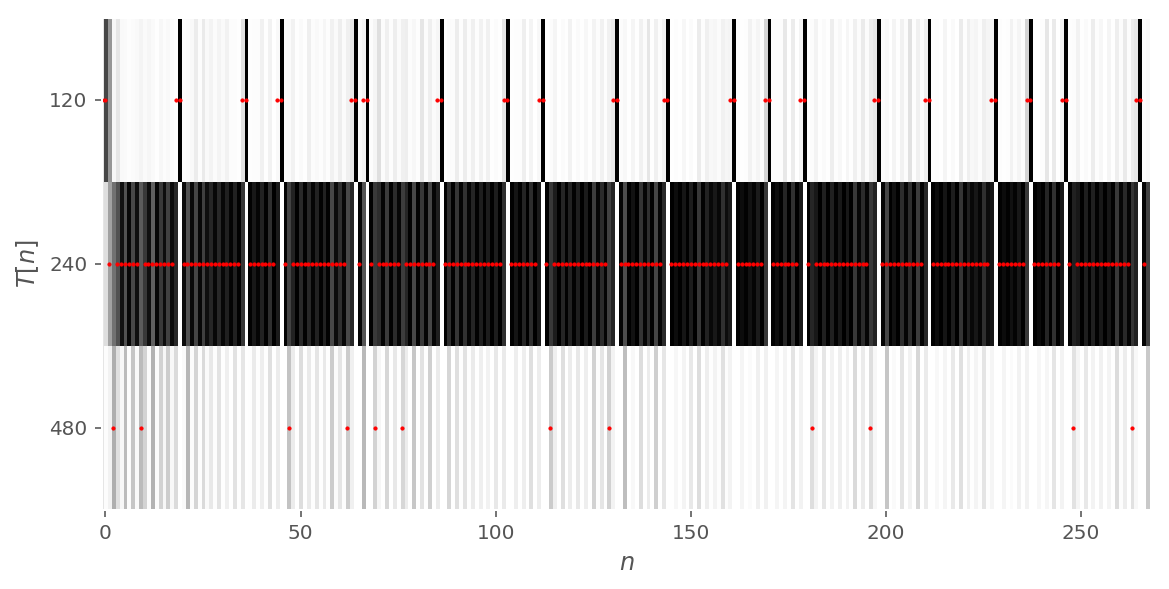

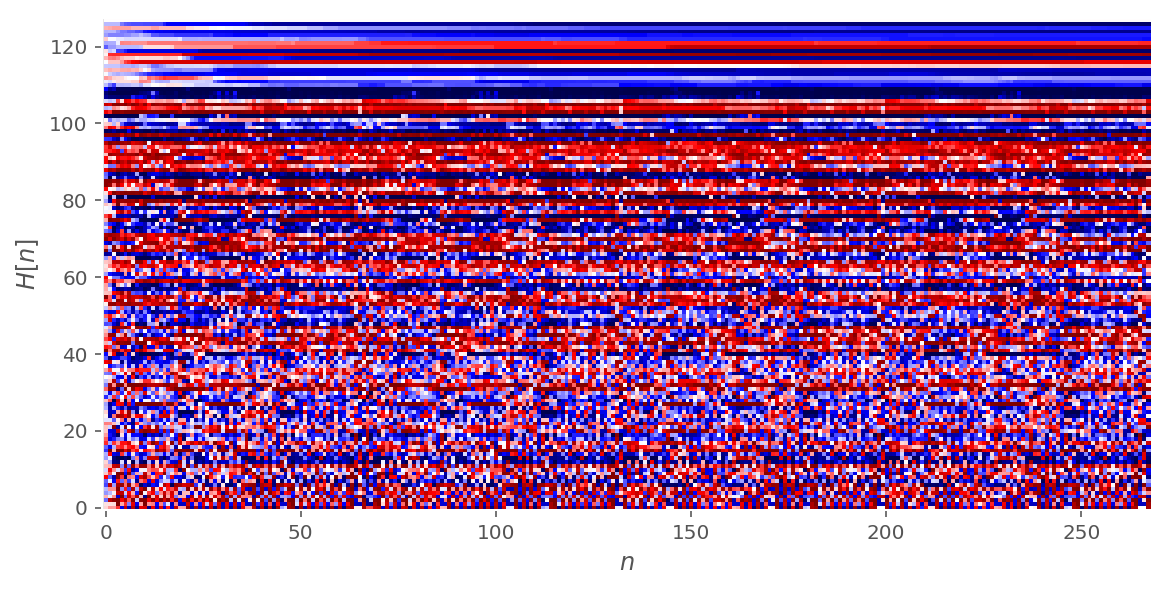

Melody #272. Accuracy T : 0.8882. Accuracy P : 0.5176.


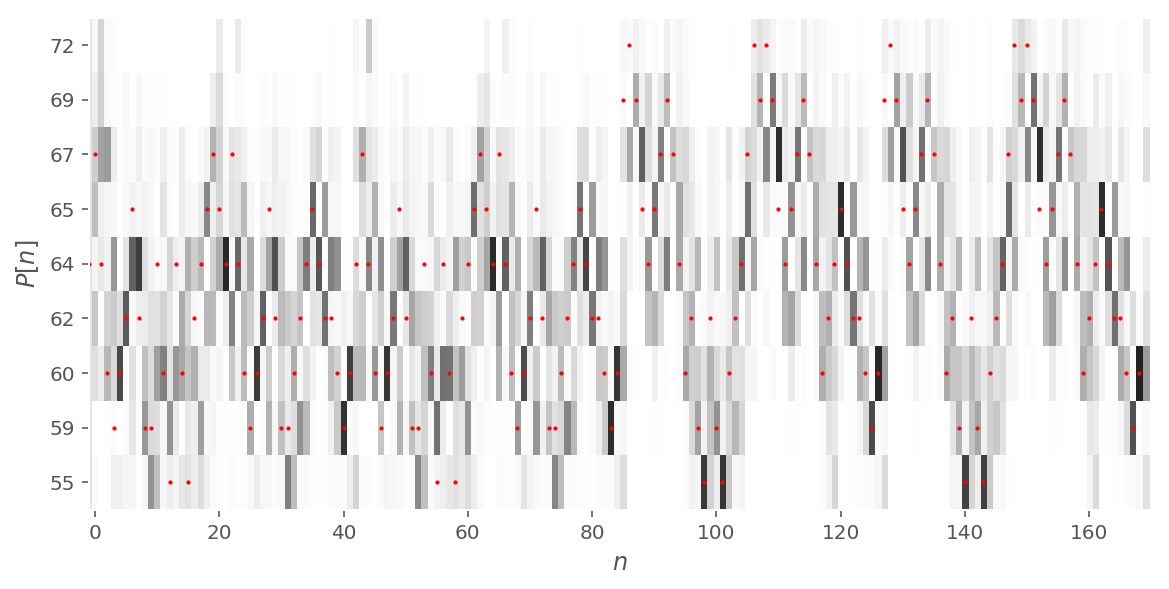

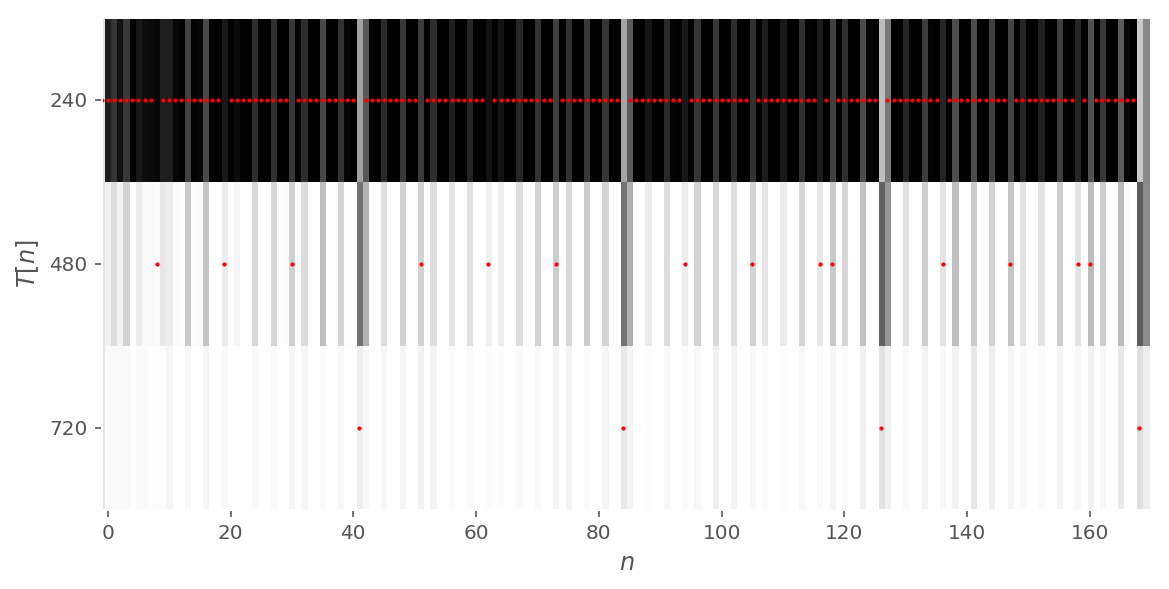

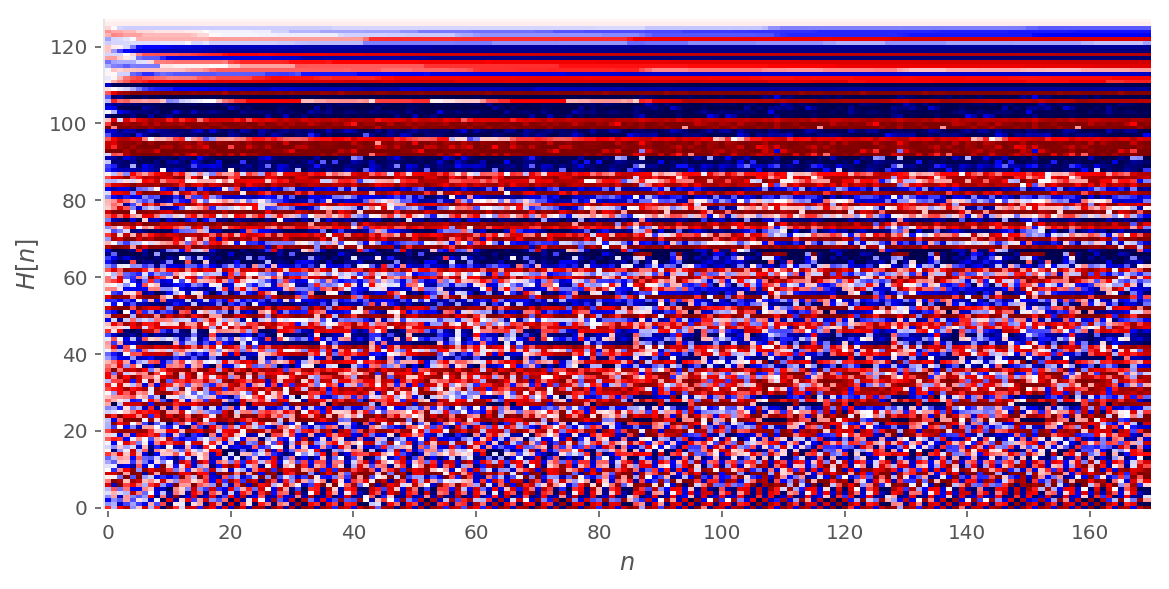

In [25]:
for index, melody in enumerate(random_melodies):
    prediction_T, prediction_P = model.predict([data_T[melody:(melody + 1)],
                                                data_P[melody:(melody + 1)]])
    prediction_T, prediction_P = prediction_T[0], prediction_P[0]
    
    metrics = model.evaluate([data_T[melody:(melody + 1)],
                              data_P[melody:(melody + 1)]],
                             [targets_T[melody:(melody + 1)],
                              targets_P[melody:(melody + 1)]],
                             verbose=0)
    accuracy_T = metrics[3]
    accuracy_P = metrics[4]
    
    hidden_state = hidden_state_model.predict([data_T[melody:(melody + 1)],
                                               data_P[melody:(melody + 1)]])
    hidden_state = hidden_state[0]
    
    print('Melody #{0}. Accuracy T : {1}. Accuracy P : {2}.'.format(melody,
                                                                    round(accuracy_T, 4),
                                                                    round(accuracy_P, 4)))
    plotMelody(one_hot_dataset_P[melody], one_hot_dataset_T[melody],
               dictionaries,
               prediction_P, prediction_T,
               hidden_state)

**3.** For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

In [28]:
model_rnn = buildModel(dictionaries, batch_length, dropout=0.2, activation='RNN')
model_rnn.load_weights('data2/rnn/rnn.272-2.23.hdf5')

model_gru = buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU')
model_gru.load_weights('data2/gru/gru.277-2.03.hdf5')

hidden_state_model_rnn = build_hidden_state_model(model_rnn)
hidden_state_model_gru = build_hidden_state_model(model_gru)

hidden_state_rnn = hidden_state_model_rnn.predict([data_T, data_P])
hidden_state_gru = hidden_state_model_gru.predict([data_T, data_P])

In [29]:
diff_rnn = np.diff(hidden_state_rnn, axis=1)
diff_gru = np.diff(hidden_state_gru, axis=1)

diff_rnn = np.abs(diff_rnn)
diff_gru = np.abs(diff_gru)

average_rnn = np.mean(diff_rnn, axis=(0, 1))
average_gru = np.mean(diff_gru, axis=(0, 1))

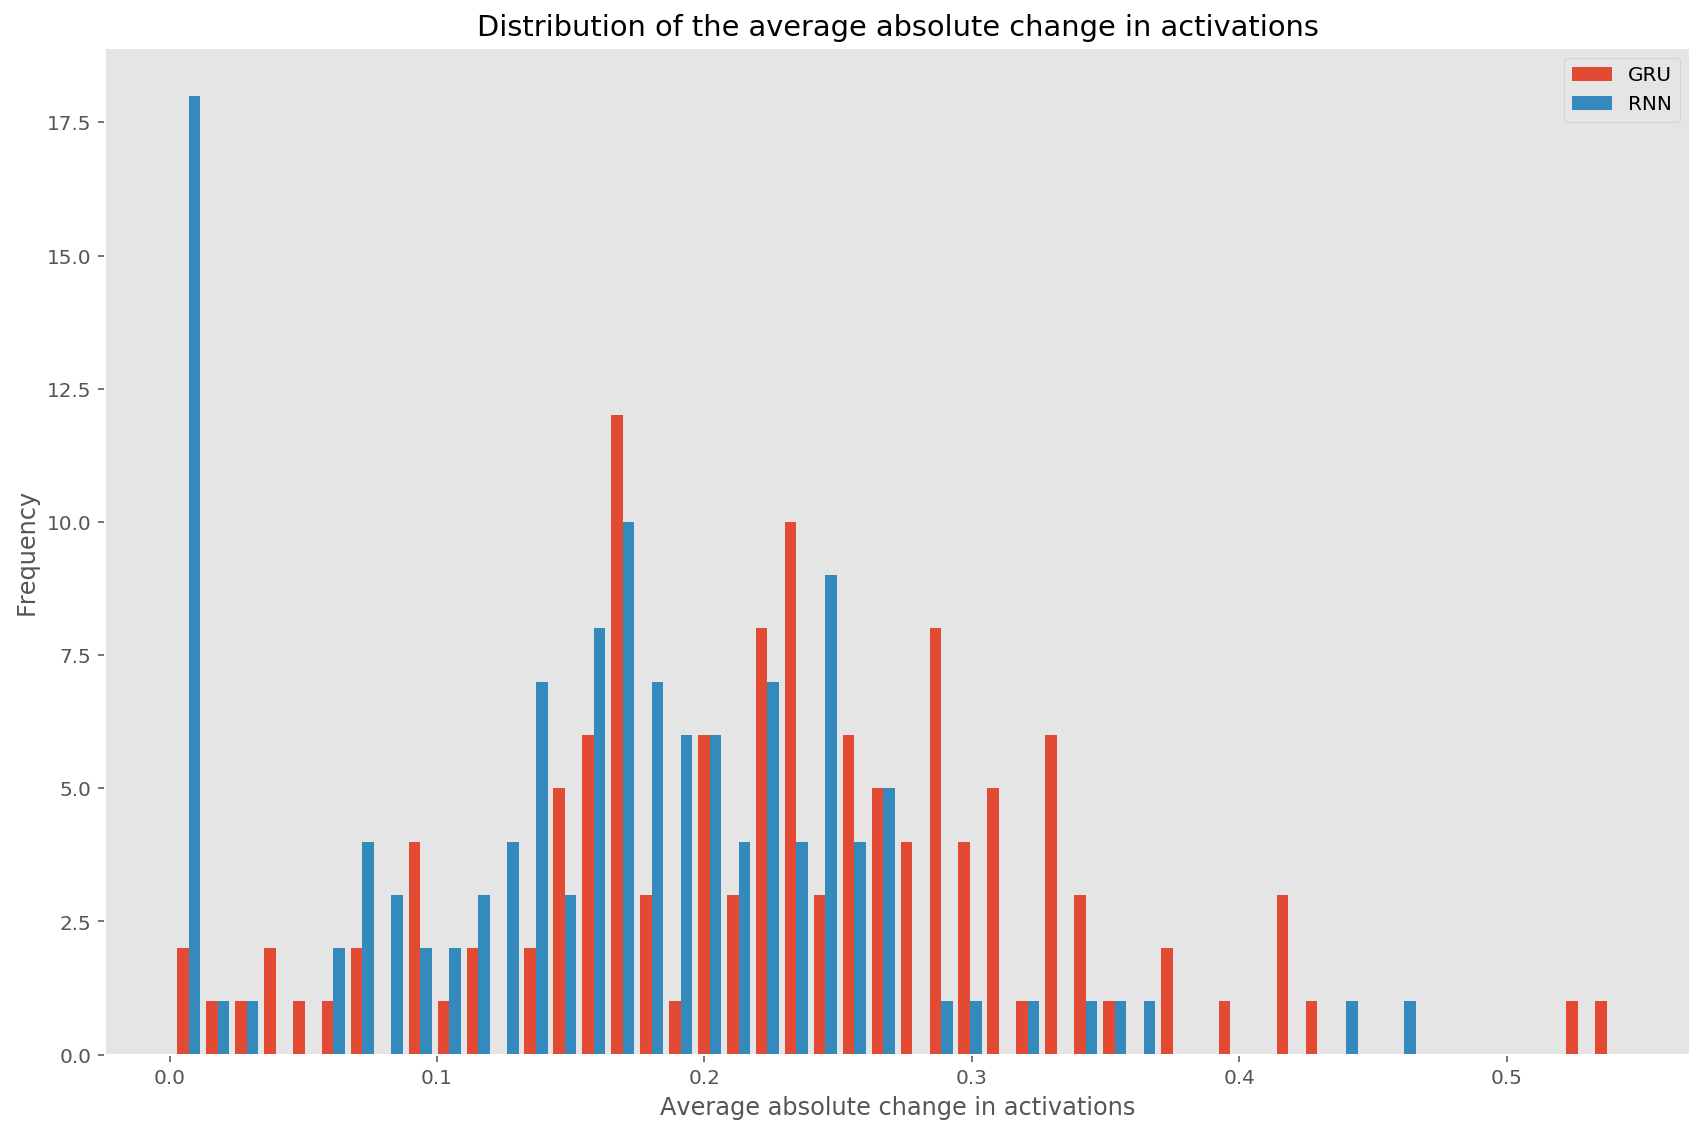

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist([average_rnn, average_gru], bins=50, label=['GRU', 'RNN'])
ax.set_title('Distribution of the average absolute change in activations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Average absolute change in activations')
ax.legend()

plt.tight_layout()

plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

**1.** We load the best model (GRU) and define a function `generate_melody` that starts from a random note and iteratively feeds the previous notes to the model to compute the next one.

In [8]:
model_rnn = buildModel(dictionaries, batch_length, dropout=0.2, activation='RNN')
model_rnn.load_weights('data2/rnn/rnn.272-2.23.hdf5')

model_gru = buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU')
model_gru.load_weights('data2/gru/gru.277-2.03.hdf5')

In [9]:
def generate_melody(model, filename, temperature=1.):
    num_durations = len(dictionaries['T'])
    num_pitches = len(dictionaries['P'])
    
    initial_duration = np.random.randint(num_durations)
    initial_pitch = np.random.randint(num_pitches)
    durations = np.zeros((1, batch_length + 1, num_durations))
    pitches = np.zeros((1, batch_length + 1, num_pitches))
    durations[0, 0, initial_duration] = 1
    pitches[0, 0, initial_pitch] = 1
    
    for index in range(batch_length):
        predictions_T, predictions_P = model.predict([durations[:, :-1, :], pitches[:, :-1, :]])
        predictions_T, predictions_P = predictions_T[0], predictions_P[0]
        
        new_duration = sample(predictions_T[index], temperature=temperature)
        new_pitch = sample(predictions_P[index], temperature=temperature)
        
        durations[0, index + 1, new_duration] = 1
        pitches[0, index + 1, new_pitch] = 1
    
    durations = durations[0]
    pitches = pitches[0]
    
    durations = [np.argmax(durations[index]) for index in range(batch_length + 1)]
    pitches = [np.argmax(pitches[index]) for index in range(batch_length + 1)]
    
    writeMIDI(pitches, durations, dictionaries, filename)

In [10]:
generate_melody(model_gru, 'data2/music/gru/GRU_0.mid')

In [12]:
print('GRU')
music21.midi.translate.midiFilePathToStream('data2/music/gru/GRU_0.mid').show('midi')

GRU


In [13]:
generate_melody(model_rnn, 'data2/music/rnn/RNN_0.mid')

In [14]:
print('RNN')
music21.midi.translate.midiFilePathToStream('data2/music/rnn/RNN_0.mid').show('midi')

RNN


**2.** We try here to generate musics with different sampling temperatures to see the effect of this parameter.

In [15]:
temperatures = [0.1, 0.5, 1, 1.5, 2, 10]
models = [model_gru, model_rnn]

filename_gru = 'data2/music/gru/GRU_t={}.mid'
filename_rnn = 'data2/music/rnn/RNN_t={}.mid'

for temperature in temperatures:
    generate_melody(model_gru, filename_gru.format(temperature))
    generate_melody(model_rnn, filename_rnn.format(temperature))

**3.** We generate here 32 melodies with both the RNN and the GRU models and using a sampling temperature of 1.

In [16]:
filename_gru = 'data2/music/gru/GRU_{}.mid'
filename_rnn = 'data2/music/rnn/RNN_{}.mid'

for index in range(32):
    generate_melody(model_gru, filename_gru.format(index + 1))
    generate_melody(model_rnn, filename_rnn.format(index + 1))

**4.**

In [21]:
gru_indexes = np.random.choice(range(1, 33), 2)
rnn_indexes = np.random.choice(range(1, 33), 2)

print('Reading the two random GRU melodies')

music21.midi.translate.midiFilePathToStream(filename_gru.format(gru_indexes[0])).show('midi')
music21.midi.translate.midiFilePathToStream(filename_gru.format(gru_indexes[1])).show('midi')

print('Reading the two random RNN melodies')

music21.midi.translate.midiFilePathToStream(filename_gru.format(rnn_indexes[0])).show('midi')
music21.midi.translate.midiFilePathToStream(filename_gru.format(rnn_indexes[1])).show('midi')

Reading the two random GRU melodies


Reading the two random RNN melodies


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: The sampling temperature has an impact on the probability weights given to the `sample` function. When the temperature is large, transitions with low probabilities have higher chance to be picked. Reciprocally, when the temperature is low, .....

**Question**: Are the generated melodies from the RNN model different from the ones generated by the GRU model? If yes, what are the main differences?

**Answer**: 

